In [1]:
import os
import h5py
import numpy as np
from IPython.lib.deepreload import reload
import matplotlib.pyplot as plt
from collections import OrderedDict
import skimage.io as io
from tqdm import tqdm
import time as ttime

%matplotlib qt

In [2]:
import xrdmaptools
from xrdmaptools.XRDMap import XRDMap
from xrdmaptools.reflections.SpotModels import GaussianFunctions
reload(xrdmaptools);

c:\Users\emusterma\AppData\Local\anaconda3\envs\sXRDMap-py311-1.0\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


Connecting to databrokers...failed.


In [11]:
# Does not work as well
from skimage.measure import label
from xrdmaptools.utilities.utilities import arbitrary_center_of_mass
from xrdmaptools.utilities.image_corrections import rescale_array

# Based on full blobs
pseudo_map = np.empty((91, 216))
pseudo_map[:] = np.nan
num_images = np.prod(pseudo_map.shape)

tth_cen_map = pseudo_map.copy()
tth_fwhm_map = pseudo_map.copy()
chi_cen_map = pseudo_map.copy()
chi_fwhm_map = pseudo_map.copy()

tth_range = (34, 35.5)
tth_mask = np.all([test.tth_arr > tth_range[0], test.tth_arr < tth_range[-1]], axis=0)

for index in tqdm(range(num_images)):
    indices = np.unravel_index(index, pseudo_map.shape)

    test_image = test.map.images[indices].copy()
    test_image *= test.map.spot_masks[indices]
    test_image *= tth_mask

    if np.sum(test_image) == 0:
        tth_cen_map[indices] = 0
        tth_fwhm_map[indices] = 0
        chi_cen_map[indices] = 0
        chi_fwhm_map[indices] = 0
        continue

    else:
        #cen = arbitrary_center_of_mass(test_image.flatten(), test.tth_arr.flatten(), test.chi_arr.flatten())

        center = arbitrary_center_of_mass(test_image, test.tth_arr, test.chi_arr)

        aweights = rescale_array(test_image, lower=0, upper=1).flatten()
        std_tth = np.sqrt(np.cov(test.tth_arr.flatten(),
                                    aweights=aweights))
        fwhm_tth = std_tth * 2 * np.sqrt(2 * np.log(2))
        
        std_chi = np.sqrt(np.cov(test.chi_arr.flatten(),
                                    aweights=aweights))
        fwhm_chi = std_chi * 2 * np.sqrt(2 * np.log(2))

        tth_cen_map[indices] = center[0]
        tth_fwhm_map[indices] = fwhm_tth
        chi_cen_map[indices] = center[1]
        chi_fwhm_map[indices] = fwhm_chi

    pseudo_map[indices] = val

  0%|          | 41/19656 [00:00<00:36, 539.31it/s]


IndexError: index 41 is out of bounds for axis 1 with size 41

In [ ]:
test.plot_map(tth_fwhm_map)

In [ ]:
test.plot_image(test_image)

In [ ]:
tth_range = (34, 35.5)
tth_mask = np.all([test.tth_arr > tth_range[0], test.tth_arr < tth_range[-1]], axis=0)

In [ ]:
test.plot_image(test.map.images[21, 172] * (tth_mask * test.map.spot_masks[21, 172]))

In [ ]:
test.plot_map(test.map.sum_map)

In [ ]:
# Based on spots
pseudo_map = np.empty((91, 216))
pseudo_map[:] = np.nan
num_images = np.prod(pseudo_map.shape)

tth_range = (34.5, 35)

for index in tqdm(range(num_images)):
    indices = np.unravel_index(index, pseudo_map.shape)

    pixel_spots = test.spots[(test.spots['map_x'] == indices[0])
                        & (test.spots['map_y'] == indices[1])]
    
    if len(pixel_spots['guess_int']) > 1:
        tth_mask = np.all([pixel_spots['guess_cen_tth'] > tth_range[0], pixel_spots['guess_cen_tth'] < tth_range[1]], axis=0)
        if np.sum(tth_mask) < 1:
            continue

        index = np.argmax(pixel_spots['guess_int'][tth_mask])
        
        val = pixel_spots[tth_mask].iloc[index]['guess_cen_tth']
    else:
        continue

    pseudo_map[indices] = val

100%|██████████| 19656/19656 [01:11<00:00, 275.04it/s]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(pseudo_map)
fig.colorbar(im, ax=ax)

fig.show()

In [ ]:
test.plot_interactive_map(display_map=pseudo_map, img_vmin=0, img_vmax=1, map_vmin=34.575, map_vmax=34.86)

In [ ]:
from xrdmaptools.utilities.utilities import delta_array

chi_step = 0.1
tth_range = (27, 31)

tth_mask = np.all([test.tth_arr > tth_range[0], test.tth_arr < tth_range[1]], axis=0)
test_image = test.map.images[21, 172].copy()
test_image *= tth_mask


chi_arr = test.chi_arr.copy()

max_chi = np.max(np.abs(chi_arr))
delta_chi = delta_array(chi_arr)

# Modular shift values if there is a discontinuity
if np.max(delta_chi) > max_chi:
    if max_chi > np.pi:
        shift_value = 2 * 180
    else:
        shift_value = 2 * np.pi

    chi_arr[chi_arr < 0] += shift_value

chi = np.arange(np.min(chi_arr), np.max(chi_arr), chi_step)


xrd_sum_list = []
xrd_num_list = []
xrd_max_list = []
xrd_mean_list = []

for chi_i in chi:    
    chi_mask = np.all([chi_arr > chi_i - chi_step / 2,
                       chi_arr < chi_i + chi_step / 2], axis=0)
    
    xrd_num = np.sum(chi_mask)
    if xrd_num > 0:
        xrd_max = np.max(test_image[chi_mask])
        xrd_sum = np.sum(test_image[chi_mask])
    else:
        xrd_max = 0
        xrd_sum = 0
    

    xrd_sum_list.append(xrd_sum)
    xrd_num_list.append(xrd_num)
    xrd_max_list.append(xrd_max)
    xrd_mean_list.append(xrd_sum / xrd_num)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(chi, xrd_max_list)

fig.show()

In [ ]:
cif_dir = 'C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'
test.load_phase('Unknown\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 new")
test.load_phase('Barker\\1521772COD.cif', filedir=cif_dir, phase_name="LiNbO3 161")
test.load_phase('Barker\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 148")

XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element Nb used instead of Nb+5
XU.materials: Warning: element Li used instead of Li+1


In [3]:
scanid = 153126
scanid = 153076
scanid = 153076
#scanid = 153248

filedir = 'D:\\Musterman_postdoc\\20240223_Musterman\\testing_maps\\'
#filedir = 'C:\\Users\\emusterma\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Data\\Condensed datasets\\'
map_filename = f'scan{scanid}_dexela_xrd.tif'
h5_filename = f'scan{scanid}_xrd.h5'

try:
    test = XRDMap.from_hdf(h5_filename, wd=filedir, save_hdf=True)
except FileNotFoundError:
    test = XRDMap.from_image_stack(map_filename, wd=filedir, energy=15, scanid=scanid, save_hdf=True)

Loading data from hdf file...
Loading most recent images (final_images)...done!
Loading most recent integrations (final_images_integrations)...done!
Loading reciprocal positions...done!
Loading scalers...done!
Loading positions...done!
Loading reflection spots...done!
Instantiating ImageMap...done!
Setting detector calibration...
XRD Map loaded!


In [10]:
base = 'D:\\Musterman_postdoc\\20240223_Musterman\\'
xrf_dir = f'{base}xrf_maps\\'

test.load_xrfmap(xrf_dir=xrf_dir)

In [21]:
test.plot_image([79, 33], spots=True)

In [12]:
plot_xrf = test.xrf['data'][:, :, :2048].copy()
plot_xrf[plot_xrf < 1e-3] = 1e-3
plot_xrf = np.log(plot_xrf)

test.plot_interactive_integration_map(plot_xrf, plot_min=0)

In [54]:
plot_xrf = test.map.integrations.copy()
plot_xrf[plot_xrf < 1e-3] = 1e-3
plot_xrf = np.log(plot_xrf)

test.plot_interactive_integration_map(plot_xrf, display_map=test.map.max_map, map_vmin=0, map_vmax=1)

In [40]:
glass = np.mean(test.map.images[22:70, 5:25], axis=(0, 1)) - np.mean(test.map.images[1:70, 2:13], axis=(0, 1))

In [41]:
test.plot_image(glass)

In [49]:
tth, integration = test.integrate1d_image(np.max(test.map.images[22:70, 5:25], axis=(0, 1)))

In [50]:
test.plot_integration(integration, tth=tth)

In [ ]:
test.plot_interactive_integration_map(test.xrf['data'][:, :, 2048])

In [79]:
os.path.join(os.path.normpath('D:/Musterman_postdoc/20240223_Musterman\\testing_maps'), 'scan153076_h5')

'D:\\Musterman_postdoc\\20240223_Musterman\\testing_maps\\scan153076_h5'

In [80]:
os.path.splitext('D:\\Musterman_postdoc\\20240223_Musterman\\testing_maps\\scan153076_xrd.h5')

('D:\\Musterman_postdoc\\20240223_Musterman\\testing_maps\\scan153076_xrd',
 '.h5')

In [55]:
test.hdf_path

'D:\\Musterman_postdoc\\20240223_Musterman\\testing_maps\\scan153076_xrd.h5'

In [122]:
test.xrf['data'].shape

(81, 41, 4096)

In [121]:
test.map.integrations.shape

(81, 41, 3086)

In [15]:
#from xrdmaptools.plot.general import _parse_xrdmap


out = _parse_xrdmap(test, [10, 32])

In [ ]:
scanid = 153126

filedir = '''D:\\Musterman_postdoc\\20240223_Musterman\\xrd_maps\\'''
map_filename = f'scan{scanid}_dexela_xrd.tif'
h5_filename = f'scan{scanid}_xrd.h5'

try:
    test = XRDMap.from_hdf(h5_filename, wd=filedir, save_hdf=False)
except FileNotFoundError:
    test = XRDMap.from_image_stack(map_filename, wd=filedir, energy=15, scanid=scanid, save_hdf=False)

Loading data from hdf file...
Loading most recent images (raw_images)...done!
Loading scalers...done!
Loading positions...done!
Instantiating ImageMap...done!
XRD Map loaded!


In [ ]:
test.plot_interactive_map(display_map=test.map.max_map, img_vmin=0, img_vmax=1e3)

In [ ]:
filedir = 'D:\\Musterman_postdoc\\20240223_Musterman\\calibrations\\new\\'

test.set_calibration('scan153043_dexela_calibration.poni', filedir=filedir)
#test.set_calibration('scan153220_dexela_calibration_ext.poni', filedir=filedir)

Setting detector calibration...


In [ ]:
test.plot_image(test.tth_arr)

In [ ]:
dark_field = io.imread(f'{filedir}dexela_df_avg.tif')
scaled_df = np.median(test.map.images) * dark_field / np.median(dark_field)
test.map.correct_dark_field(dark_field=scaled_df)

Correcting dark-field...done!


In [ ]:
dark_id = 153074
#dark_id = 153086

dark_dir = 'D:\\Musterman_postdoc\\20240223_Musterman\\dark_fields\\'
dir_mask = [str(dark_id) in d for d in os.listdir(dark_dir)]

dark_field = io.imread(f'{dark_dir}{np.array(os.listdir(dark_dir))[dir_mask][0]}').astype(np.float32)
test.map.correct_dark_field(dark_field=dark_field)

Correcting dark-field...done!


In [ ]:
sclr_arr = test.map.med_map
sclr_arr -= np.min(sclr_arr)
sclr_arr += np.mean(sclr_arr)
test.map.normalize_scaler(scaler_arr = sclr_arr)

Normalize image by input scaler...done!


In [ ]:
#test.map.correct_outliers()
test.map.normalize_scaler()

Normalize image by i0 scaler...done!


In [ ]:
test.map.apply_polarization_correction()
test.map.apply_solidangle_correction()

Applying X-ray polarization correction...done!
Applying solid angle correction...done!


In [ ]:
from xrdmaptools.utilities.utilities import delta_array
omega = 4 * np.arcsin(np.sin(np.radians(test.delta_tth / 2)) * np.sin(np.radians(test.delta_chi / 2)))

#test.map.images /= (omega * np.sin(np.radians(test.tth_arr)))
test.map.images /= (omega)
test.map.corrections['lorentz'] = True

In [ ]:
test.map.corrections

{'absorption': False,
 'background': False,
 'dark_field': True,
 'flat_field': False,
 'lorentz': True,
 'outliers': False,
 'pixel_defects': False,
 'pixel_distortions': False,
 'polar_calibration': False,
 'polarization': True,
 'scaler_intensity': True,
 'solid_angle': True}

In [ ]:
test.map.rescale_images(arr_min=0, upper=100, lower=0)

In [ ]:
test.plot_interactive_map(display_map=test.map.sum_map, map_vmin=6e3, img_vmin=0, img_vmax=0.1)

In [25]:
base = 'D:\\Musterman_postdoc\\20240223_Musterman\\'
xrf_dir = f'{base}xrf_maps\\'

with h5py.File(f'{xrf_dir}scan2D_{test.scanid}_xs_sum8ch.h5', 'r') as f:

    xrf_fit_names = [d.decode('utf-8') for d in f['xrfmap/detsum/xrf_fit_name'][:]]
    xrf_fit = f['xrfmap/detsum/xrf_fit'][:]

    i0 = f['xrfmap/scalers/val'][..., 0]
    xrf_fit = np.concatenate((xrf_fit, np.expand_dims(i0, axis=0)), axis=0)
    xrf_fit = np.transpose(xrf_fit, axes=(0, 2, 1))
    xrf_fit_names.append('i0')

    xrf_dict = dict(zip(xrf_fit_names, xrf_fit))

    
    xrfmap = f['xrfmap/detsum/counts'][:]
    xrf_energy = f['xrfmap/scan_metadata'].attrs['instrument_mono_incident_energy']
    
#xrf_energy = np.arange(xrfmap.shape[-1]) / 100

In [26]:
xrf_energy

20.0

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(xrf_energy, np.mean(xrfmap[10:21, 28:29], axis=(0, 1)))
ax.set_yscale('log')

ax.set_xlim(0, 20.5)
ax.set_ylim(1e-0)

ax.set_xlabel('Energy [keV]')
ax.set_ylabel('Intensity [a.u.]')

fig.show()

In [ ]:
test.map.finalize_images()

Caution: Images not corrected for:
	absorption
	background
	flat_field
	outliers
	pixel_defects
	pixel_distortions
	polar_calibration
Cleaning and updating image information...
Diffraction map size is 4.618 GB.
Compressing and writing images to disk.
This may take awhile...
done!


In [ ]:
test.integrate1d_map()

Integrated images to 1D...

100%|██████████| 3321/3321 [01:15<00:00, 44.12it/s]


In [ ]:
from xrdmaptools.utilities.math import tth_2_d, d_2_tth, energy_2_wavelength, tth_2_q, q_2_tth
from xrdmaptools.reflections.SpotModels import GaussianFunctions, LorentzianFunctions
from itertools import permutations
from itertools import product



# Re-write for the crystal class...
def metric_tensor(a, b, c, alpha, beta, gamma):
    A = a**2
    B = b**2
    C = c**2
    D = 2 * b * c * np.cos(alpha)
    E = 2 * a * c * np.cos(beta)
    F = 2 * a * b * np.cos(gamma)
    return (A, B, C, D, E, F)

def S_tensor(a, b, c, alpha, beta, gamma):
    V = a * b * c * np.sqrt(1
                            - np.cos(alpha)**2
                            - np.cos(beta)**2
                            - np.cos(gamma)**2
                            - 2 * np.cos(alpha) * np.cos(beta) * np.cos(gamma))
    S11 = b**2 * c**2 * np.sin(alpha)**2
    S22 = a**2 * c**2 * np.sin(beta)**2
    S33 = a**2 * b**2 * np.sin(gamma)**2
    S12 = a * b * c**2 * (np.cos(alpha) * np.cos(beta) - np.cos(gamma))
    S23 = a**2 * b * c * (np.cos(beta) * np.cos(gamma) - np.cos(alpha))
    S13 = a * b**2 * c * (np.cos(gamma) * np.cos(alpha) - np.cos(beta))

    return (V, S11, S22, S33, S12, S23, S13)


def hkl_2_d(hkls, a, b, c, alpha, beta, gamma):
    VS = np.round(S_tensor(a, b, c, alpha, beta, gamma), 8)

    d_list = []
    for hkl in hkls:
        h, k, l = hkl
        d = VS[0] * (VS[1] * (h**2)
                     + VS[2] * (k**2)
                     + VS[3] * (l**2)
                     + VS[4] * (h * k) * 2
                     + VS[5] * (k * l) * 2
                     + VS[6] * (h * l * 2)
                     )**(-0.5)
        
        d_list.append(d)
    
    return np.array(d_list)


def d_spacings(q_range, a, b, c, alpha, beta, gamma):
    q_min, q_max = q_range
    
    possible_hkls = list(product(range(10), repeat=3))[1:]

    VS = np.round(S_tensor(a, b, c, alpha, beta, gamma), 8)

    d_list = []
    for hkl in possible_hkls:
        h, k, l = hkl
        d = VS[0] * (VS[1] * (h**2)
                     + VS[2] * (k**2)
                     + VS[3] * (l**2)
                     + VS[4] * (h * k) * 2
                     + VS[5] * (k * l) * 2
                     + VS[6] * (h * l * 2)
                     )**(-0.5)
        
        if 2 * np.pi / d < q_min:
            continue
        elif 2 * np.pi / d > q_max:
            continue
        else:
            d_list.append(d)
    
    d_list = np.unique(np.round(d_list, 8))
        
    return sorted(d_list, reverse=True)


def pattern_estimate_guess(tth, intensity, a, b, c, alpha, beta, gamma, wavelength=test.wavelength, window=20):
    q = tth_2_q(tth, wavelength=wavelength)
    q[np.isnan(q)] = 0
    q_range = [np.min(q), np.max(q)]

    d = d_spacings(q_range, a, b, c, alpha, beta, gamma)
    q_cen = 2 * np.pi / np.array(d)

    args = []
    for i in range(len(q_cen)):
        cen_idx = np.argmin(np.abs(q - q_cen[i]))
        amp = intensity[cen_idx]
        q_vals = q[cen_idx - window : cen_idx + window]
        int_vals = intensity[cen_idx - window : cen_idx + window]
        std_tth = np.sqrt(np.cov(q_vals, aweights=int_vals))
        fwhm = std_tth * 2 * np.sqrt(2 * np.log(2))

        args.extend([
            amp,
            fwhm
        ]) 
    
    return args


def pattern_estimate(tth, *args, wavelength=test.wavelength):
    a, b, c, alpha, beta, gamma = args[:6]
    int_fwhm = args[6:]
    
    q = tth_2_q(tth, wavelength=wavelength)
    q[np.isnan(q)] = 0
    q_range = [np.min(q), np.max(q)]

    d = d_spacings(q_range, a, b, c, alpha, beta, gamma)
    q_cen = 2 * np.pi / np.array(d)

    args = [0]
    for i in range(len(q_cen)):
        args.extend([
            int_fwhm[::2][i],
            q_cen[i],
            int_fwhm[1::2][i]
        ])

    intensity = LorentzianFunctions.multi_1d(q, *args)

    return intensity


def pattern_estimate_from_phase_guess(tth, intensity, window=20):
    phases = [test.phases['304SS-austenite'],
              test.phases['platinum'],
              test.phases['tungsten_2']]

    q = tth_2_q(tth, wavelength=test.wavelength)
    q[np.isnan(q)] = 0

    d = []
    for phase in phases:
        lattice_params = list(phase.lattice._parameters.values())
        lattice_params[3:] = np.radians(lattice_params[3:])

        d.extend(hkl_2_d(phase.reflections['hkl'],
                         *lattice_params))

    q_cen = 2 * np.pi / np.array(d)

    args = [np.min(intensity[20:-20])]
    for i in range(len(q_cen)):
        cen_idx = np.argmin(np.abs(q - q_cen[i]))
        amp = intensity[cen_idx] - np.min(intensity)
        
        q_vals = q[cen_idx - window : cen_idx + window]
        int_vals = intensity[cen_idx - window : cen_idx + window]
        int_vals[int_vals < 0] = 0
        
        std_tth = np.sqrt(np.cov(q_vals, aweights=int_vals))
        fwhm = std_tth * 2 * np.sqrt(2 * np.log(2))

        args.extend([
            amp,
            fwhm
        ])

    return args


def pattern_estimate_from_phase(tth, *args):
    phases = [test.phases['304SS-austenite'],
              test.phases['platinum'],
              test.phases['tungsten_2']]
    lattice_params = np.array(args[:6 * len(phases)]).reshape(-1, 6)
    offset = args[6 * len(phases)]
    int_fwhm = args[6 * len(phases) + 1:]

    q = tth_2_q(tth, wavelength=test.wavelength)
    q[np.isnan(q)] = 0

    d = []
    for i, phase in enumerate(phases):
        d.extend(hkl_2_d(phase.reflections['hkl'],
                         *lattice_params[i]))
    
    q_cen = 2 * np.pi / np.array(d)

    args = [offset]
    for i in range(len(q_cen)):
        args.extend([
            int_fwhm[::2][i],
            q_cen[i],
            int_fwhm[1::2][i]
        ])

    intensity = LorentzianFunctions.multi_1d(q, *args)

    return intensity

def generate_bounds(phases, args):

    lattice_params = np.array(args[:6 * len(phases)]).reshape(-1, 6)
    offset = args[6 * len(phases)]
    int_fwhm = args[6 * len(phases) + 1:]

    low_bounds, upr_bounds = [], []

    for lattice_params_i in lattice_params:
        a, b, c, alpha, beta, gamma = lattice_params_i

        for const in [a, b, c]:
            # Ridiculous bounds of 5% strain
            low_bounds.append(0.95 * const)
            upr_bounds.append(1.05 * const)
        
        for angle in [alpha, beta, gamma]:
            low_bounds.append(angle - np.radians(5))
            upr_bounds.append(angle + np.radians(5))

    # offset bound
    low_bounds.append(0)
    upr_bounds.append(5 * offset)

    # amp and fwhm
    for i, val in enumerate(int_fwhm):
        if i % 2 == 0: # even, amp
            low_bounds.append(0)
            upr_bounds.append(3 * val)
        else: # odd, fwhm
            low_bounds.append(0.001)
            upr_bounds.append(3 * val)

    return [low_bounds, upr_bounds]


In [ ]:
map_indices = (8, 31)

lattice_params = [3.53, 3.52, 3.529, np.radians(90), np.radians(90), np.radians(90)]

lattice_params = []
for phase in [test.phases['304SS-austenite'],
              test.phases['platinum'],
              test.phases['tungsten_2']]:
    lattice_params_i = list(phase.lattice._parameters.values())
    lattice_params_i[3:] = np.radians(lattice_params_i[3:])
    lattice_params.extend(lattice_params_i)
#p0 = pattern_estimate_guess(test.tth, test.map.integrations[map_indices], *lattice_params, wavelength=test.wavelength)
#p_guess = lattice_params + p0

p0 = pattern_estimate_from_phase_guess(test.tth, test.map.integrations[map_indices])
p_guess = lattice_params + p0

intensity = pattern_estimate_from_phase(test.tth, *p_guess)

bounds = generate_bounds([test.phases['304SS-austenite'],
              test.phases['platinum'],
              test.phases['tungsten_2']], p_guess)

In [ ]:
from scipy.optimize import curve_fit
from xrdmaptools.utilities.math import compute_r_squared

#popt, pcov = curve_fit(pattern_estimate, test.tth, test.map.integrations[map_indices], p0=p_guess)
popt, pcov = curve_fit(pattern_estimate_from_phase, test.tth, test.map.integrations[map_indices], p0=p_guess, maxfev=1000, bounds=bounds)
r_squared = compute_r_squared(test.map.integrations[map_indices], pattern_estimate_from_phase(test.tth, *popt))
print(r_squared)
fit_int = pattern_estimate_from_phase(test.tth, *popt)

0.7831190731325022


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, test.map.integrations[map_indices], c='k', label='data')
ax.plot(test.tth, intensity, '--', c='k', alpha=0.5, label='guess', lw=1)
ax.plot(test.tth, fit_int, '--', c='r', label='fit')
ax.plot(test.tth, test.map.integrations[map_indices] - fit_int - 0.1, c='gray', label='residual')

ax.legend()

fig.show()

In [ ]:
test.plot_interactive_integration_map()

In [ ]:
from sklearn.decomposition import PCA

n_components = 12

#X = xrfmap.copy().T
X = rescale_array(xrfmap.copy().T, arr_min=0, upper=100)
X = test.map.integrations.copy().T
#X = np.vstack([rescale_array(xrfmap.copy().T, arr_min=0, upper=100), test.map.integrations.copy().T])

h, w = X.shape[1], X.shape[2]

print("Extracting the top %d eigenpatterns from %d patterns"
      % (n_components, X.shape[0]))
t0 = ttime.time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X.reshape(len(X), h * w))

x_pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit_transform(X.reshape(len(X), h * w))

eigen = pca.components_.reshape((n_components, h, w))

print("done in %0.3fs" % (ttime.time() - t0))

Extracting the top 12 eigenpatterns from 3086 patterns
done in 0.359s


In [ ]:
from sklearn.decomposition import NMF

n_components = 6

#X = xrfmap.copy().T
X = rescale_array(xrfmap.copy().T, arr_min=0, upper=100)
#X = test.map.integrations.copy().T
#X = np.vstack([rescale_array(xrfmap.copy().T, arr_min=0, upper=100), test.map.integrations.copy().T])
X[X < 0] = 0

h, w = X.shape[1], X.shape[2]

print("Extracting the top %d eigenpatterns from %d patterns"
      % (n_components, X.shape[0]))
t0 = ttime.time()
pca = NMF(n_components=n_components).fit(X.reshape(len(X), h * w))

x_pca = NMF(n_components=n_components).fit_transform(X.reshape(len(X), h * w))

eigen = pca.components_.reshape((n_components, h, w))

print("done in %0.3fs" % (ttime.time() - t0))

Extracting the top 6 eigenpatterns from 4096 patterns


c:\Users\emusterma\AppData\Local\anaconda3\envs\sXRDMap-py311-1.0\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 3.131s


c:\Users\emusterma\AppData\Local\anaconda3\envs\sXRDMap-py311-1.0\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(5, 5), dpi=200)


for i, axi in enumerate(axes):

    axi[0].imshow(eigen[i])
    axi[0].set_xticks([])
    axi[0].set_yticks([])

    #axi[1].plot(xrf_energy, x_pca[:, i])
    #axi[1].plot(test.tth, x_pca[:, i])
    plot_plot = x_pca[:, i]
    axi[1].plot(xrf_energy, plot_plot)
    #axi[1].plot(test.tth, plot_plot)
    axi[1].set_ylim(np.min(plot_plot), np.max(plot_plot))
    axi[1].set_yticks([])

fig.show()

In [ ]:
len(test.tth)

3086

In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(5, 5), dpi=200)


for i, axi in enumerate(axes):

    axi[0].imshow(eigen[i])
    axi[0].set_xticks([])
    axi[0].set_yticks([])

    #axi[1].plot(xrf_energy, x_pca[:, i])
    #axi[1].plot(test.tth, x_pca[:, i])
    plot_plot = x_pca[:len(xrf_energy), i]
    axi[1].plot(xrf_energy, plot_plot)
    axi[1].set_ylim(np.min(plot_plot), np.max(plot_plot))
    axi[1].set_yticks([])

    #axi[2].plot(xrf_energy, x_pca[:, i])
    #axi[2].plot(test.tth, x_pca[:, i])
    plot_plot = x_pca[len(xrf_energy):, i]
    axi[2].plot(test.tth, plot_plot)
    axi[2].set_ylim(np.min(plot_plot), np.max(plot_plot))
    axi[2].set_yticks([])

fig.show()

In [ ]:
test.map_extent

[-10.203479, 9.687759, -20.038216, 20.00252]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

xrf_cen = 2700
x_signal = rescale_array(np.sum(xrfmap[:, :, xrf_cen - 15:xrf_cen + 15], axis=(-1)))
x_energy = np.mean(xrf_energy[xrf_cen - 15:xrf_cen + 15])

tth_cen = 830
y_signal = rescale_array(np.sum(test.map.integrations[:, :, tth_cen - 30:tth_cen + 30], axis=(-1)))
y_tth = np.mean(test.tth[tth_cen - 30:tth_cen + 30])

ax.scatter(x_signal, y_signal, s=1, alpha=0.5, c='k')
ax.set_xlabel(f'XRF Energy around {x_energy:.2f} keV')
ax.set_ylabel(f'XRD 2θ around {y_tth:.2f}°')

corr_signal = x_signal * y_signal

fig.show()

test.plot_map(corr_signal)

In [ ]:
xrf_dict.keys()

dict_keys(['S_K', 'Ga_K', 'Si_K', 'Sb_L', 'Ni_K', 'Fe_K', 'Ar_K', 'W_L', 'Pt_L', 'compton', 'elastic', 'snip_bkg', 'r_factor', 'sel_cnt', 'total_cnt', 'i0'])

In [ ]:
from xrdmaptools.utilities.image_corrections import rescale_array

xrf_stack = []

for key in xrf_dict.keys():
    if key in ['snip_bkg', 'r_factor', 'sel_cnt', 'total_cnt', 'i0']:
        continue

    xrf_stack.append(rescale_array(xrf_dict[key].copy()))

xrf_stack = np.stack(xrf_stack)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, np.max(test.map.integrations, axis=(0, 1)))

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

#x, bins, _ = ax.hist(test.spots['guess_cen_tth'].values, bins=2000, weights=test.spots['guess_height'].values, label='spot center', density=True)
x, bins, _ = ax.hist(test.spots['guess_cen_tth'].values, bins=2000, label='spot center', density=True)
ax.plot(test.tth, rescale_array(np.max(test.map.integrations, axis=(0, 1)), lower=np.min(x), upper=np.max(x)), label='max intensity')

ax.legend()

plt.show()

In [ ]:
test.integrate1d_map()

Integrated images to 1D...

100%|██████████| 3321/3321 [01:18<00:00, 42.25it/s]


In [ ]:
from skimage.feature import peak_local_max
from scipy.signal import find_peaks

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

plot_int = rescale_array(np.max(test.map.integrations, axis=(0, 1)))
#peaks = peak_local_max(plot_int,
#                       threshold_rel=0.05)

peaks, _ = find_peaks(plot_int, prominence=0.01, distance=4)

ax.scatter(test.tth[peaks], plot_int[peaks], s=2, c='r')
ax.plot(test.tth, plot_int)


fig.show()

In [ ]:
def generate_bounds(p0, peak_function, tth_step=None, chi_step=None):
    
    # Get function input variable names, excluding 'self', 'x' or '(xy)' and any default arguments
    inputs = list(peak_function.__code__.co_varnames[:peak_function.__code__.co_argcount])
    if 'self' in inputs: inputs.remove('self')
    inputs = inputs[1:] # remove the x, or xy inputs
    if peak_function.__defaults__ is not None:
        inputs = inputs[:-len(peak_function.__defaults__)] # remove defualts

    if tth_step is None: tth_step = 0.02
    if chi_step is None: chi_step = 0.05

    tth_resolution, chi_resolution = 0.01, 0.01 # In degrees...
    tth_range = np.max([tth_resolution, tth_step]) * 3 # just a bit more wiggle room
    chi_range = np.max([chi_resolution, chi_step]) * 3 # just a bit more wiggle room

    low_bounds, upr_bounds = [], []
    for i in range(0, len(p0), len(inputs)):
        for j, arg in enumerate(inputs):
            if arg == 'amp':
                low_bounds.append(0)
                upr_bounds.append(p0[i + j] * 10) # guess intensity is probably not off by more than this
            elif arg == 'x0':
                low_bounds.append(p0[i + j] - tth_range) # Restricting peak shift based on guess position uncertainty
                upr_bounds.append(p0[i + j] + tth_range)
            elif arg == 'y0':
                low_bounds.append(p0[i + j] - chi_range) # Restricting peak shift based on guess position uncertainty
                upr_bounds.append(p0[i + j] + chi_range)
            elif 'fwhm' in arg:
                low_bounds.append(0.001)
                upr_bounds.append(p0[i + j] * 2) # should be based off of intrument resolution
            elif 'fwhm_y' in arg:
                low_bounds.append(0.001)
                upr_bounds.append(p0[i + j] * 3) # should be based off of intrument resolution
            elif arg == 'theta':
                low_bounds.append(-45) # Prevents spinning
                upr_bounds.append(45) # Only works for degrees...
            else:
                raise ValueError(f"{peak_function} inputs {arg} not defined by the generate_bounds function!")
            
    return [low_bounds, upr_bounds]

In [ ]:
from xrdmaptools.reflections.SpotModels import GaussianFunctions, LorentzianFunctions #, generate_bounds
SpotModel = GaussianFunctions
#SpotModel = LorentzianFunctions

guess_range = 10

p0 = []
p0.append(np.min(plot_int)) # offset
for peak in peaks:
    val_ints = plot_int[peak - guess_range:peak + guess_range]
    val_tths = test.tth[peak - guess_range:peak + guess_range]

    std_tth = np.sqrt(np.cov(val_tths, aweights=val_ints))
    fwhm_tth = std_tth * 2 * np.sqrt(2 * np.log(2))

    p0.append(plot_int[peak]) # amp
    p0.append(test.tth[peak]) # x0
    p0.append(fwhm_tth) # fwhm

bounds = generate_bounds(p0[1:], SpotModel.func_1d, tth_step=None, chi_step=None)
bounds[0].insert(0, 0) # offset lower bound
bounds[1].insert(0, 1e-3) # offset upper bound


In [ ]:
from scipy.optimize import curve_fit
from xrdmaptools.utilities.math import compute_r_squared

popt, _ = curve_fit(SpotModel.multi_1d, test.tth, plot_int, p0=p0, bounds=bounds)
r_squared = compute_r_squared(plot_int, SpotModel.multi_1d(test.tth, *popt))
print(r_squared)

0.9548325546635049


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, plot_int, label='exp.')
ax.plot(test.tth, SpotModel.multi_1d(test.tth, *p0), label='guess')
ax.plot(test.tth, plot_int - SpotModel.multi_1d(test.tth, *p0) - 0.2, label='residual')

ax.legend()

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, plot_int, label='exp.')
ax.plot(test.tth, SpotModel.multi_1d(test.tth, *popt), label='fit')
ax.plot(test.tth, plot_int - SpotModel.multi_1d(test.tth, *popt) - 0.2, label='residual')

ax.legend()

fig.show()

In [ ]:
xrf_stack.shape

(16, 41, 81)

In [ ]:
peak_maps = np.empty((*test.map.map_shape, len(peaks)))

params = list(popt.copy())
params.pop(0)
for i in range(len(peaks)):
    peak_map = np.sum(test.map.integrations * SpotModel.func_1d(test.tth, *params[:3]), axis=(-1))
    peak_maps[:, :, i] = rescale_array(peak_map)
    del params[:3]

peak_maps = peak_maps.T

In [ ]:
features = np.vstack([xrf_stack, peak_maps])
features = features.reshape(features.shape[0], -1)

In [ ]:
features.shape

(56, 3321)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

x_signal = features[0]
y_signal = features[3]

ax.scatter(x_signal, y_signal, s=5, alpha=0.5, c='k')

fig.show()

In [ ]:
projections = features[:, np.newaxis] * features[np.newaxis, :]

In [ ]:
correlations = np.empty((features.shape[0], features.shape[0]))

for index in range(np.prod(correlations.shape)):
    indices = np.unravel_index(index, correlations.shape)

    correlation = np.dot(features[indices[0]], features[indices[1]]) / (np.linalg.norm(features[indices[0]]) * np.linalg.norm(features[indices[1]]))
    correlations[indices] = correlation

In [ ]:
projections.shape

(56, 56, 3321)

In [ ]:
correlations.shape

(56, 56)

In [ ]:
pairs = []

for index in range(np.prod(correlations.shape)):
    indices = np.unravel_index(index, correlations.shape)

    if (correlations[indices] > 0.95
        and indices[0] != indices[1]
        and indices[::-1] not in pairs):
        pairs.append(indices)

In [ ]:
pseudo_phases = []
assigned_features = []

for i, pair in enumerate(pairs):

    NEW_pseudo_PHASE = True
    for pseudo_phase in pseudo_phases:
        if (pair[0] in pseudo_phase
            or pair[1] in pseudo_phase):
            pseudo_phase.extend(list(pair))
            NEW_pseudo_PHASE = False
            continue

    for pseudo_phase in pseudo_phases:
        if (pair[0] in pseudo_phase
            and pair[1] in pseudo_phase):
            pseudo_phase.extend(list(pair))
            NEW_pseudo_PHASE = False
            continue
    
    if NEW_pseudo_PHASE:
        pseudo_phases.append(list(pair))

    #if i == 55:
    #    break

# Reduce to unique features
#for i, pseudo_phase in enumerate(pseudo_phases):
#    pseudo_phases[i] = list(np.unique(np.array(pseudo_phase)))

# Combined spearated correlated psued0_phases
for i, pseudo_phase in enumerate(pseudo_phases):
    for feature_i in pseudo_phase:
        matches = [feature_i in x for x in pseudo_phases]
        if np.sum(matches) > 1:
            combined_phase_index = list(np.where(matches)[0])[1] # zero index is the same, others will be combined in next pass
            pseudo_phases[i].extend(pseudo_phases[combined_phase_index])
            pseudo_phases.pop(combined_phase_index)

# Reduce to unique features
for i, pseudo_phase in enumerate(pseudo_phases):
    pseudo_phases[i] = list(np.unique(np.array(pseudo_phase)))


In [ ]:

pseudo_phases = []
for pair in pairs:

    f0 = pair[0]
    f1 = pair[1]

    f0_matches = [np.array(pair_i)[pair_i != f0][0] for pair_i in pairs if f0 in pair_i]
    f1_matches = [np.array(pair_i)[pair_i != f1][0] for pair_i in pairs if f1 in pair_i]

    f3_matches = [f3 for f3 in f0_matches if f3 in f1_matches]

    if len(f3_matches) > 0:
        pseudo_phase = [*pair, *f3_matches]
        pseudo_phases.append(pseudo_phase)



In [ ]:
# Reduce to unique features
for i, pseudo_phase in enumerate(pseudo_phases):
    pseudo_phases[i] = list(np.unique(np.array(pseudo_phase)))

In [ ]:
plot_map = np.zeros_like(features[0])

for i in pseudo_phases[-1]:
    plot_map += features[i]

test.plot_map(plot_map.reshape(test.map.map_shape[::-1]).T)

In [ ]:
ext = np.max(np.abs([np.min(correlations), np.max(correlations)]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(correlations, vmin=-ext, vmax=ext, cmap='bwr')
fig.colorbar(im, ax=ax)

fig.show()

In [ ]:
ext = np.max(np.abs([np.min(correlations), np.max(correlations)]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(np.max(projections, axis=-1))
fig.colorbar(im, ax=ax)

fig.show()

In [ ]:
xrf_dict.keys()

dict_keys(['S_K', 'Ga_K', 'Si_K', 'Sb_L', 'Ni_K', 'Fe_K', 'Ar_K', 'W_L', 'Pt_L', 'compton', 'elastic', 'snip_bkg', 'r_factor', 'sel_cnt', 'total_cnt', 'i0'])

In [ ]:
from xrdmaptools.plot.interactive_plotting import interactive_dynamic_2d_plot

interactive_dynamic_2d_plot(np.transpose(projections.reshape(61, 61, *test.map.map_shape[::-1]), (0, 1, 3, 2)),
                                display_map=np.max(projections, axis=-1), display_title=None,
                                map_vmin=None, map_vmax=None,
                                cmap='viridis', marker_color='red')

(81, 41, 3086)

In [ ]:
from skimage.transform import resize

X = np.vstack([rescale_array(resize(xrfmap.copy().T[:2048], (1024, 41, 81))), rescale_array(resize(test.map.integrations.copy().T, (1000, 41, 81)))])
X = X.astype(np.float16)

In [ ]:
raw_projections = X[:, np.newaxis] * X[np.newaxis, :]

In [ ]:
raw_projections

(2024, 2024, 41, 81)

In [ ]:
max_projections = np.max(raw_projections, axis=(2, 3))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(np.max(raw_projections, axis=(2, 3)))
fig.colorbar(im, ax=ax)

fig.show()

In [ ]:
from scipy.ndimage import gaussian_filter

out = peak_local_max(gaussian_filter(max_projections.astype(np.float32), sigma=1), threshold_rel=0.1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(np.log(max_projections))
fig.colorbar(im, ax=ax)

#ax.scatter(out[:, 0], out[:, 1], s=1, c='r')

fig.show()

In [ ]:
valid_proj = []

for spot in out:
    spot = list(spot)
    if (spot not in valid_proj
        and spot[::-1] not in valid_proj
        and spot[0] != spot[1]):
        valid_proj.append(spot)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(max_projections)
fig.colorbar(im, ax=ax)

ax.scatter(np.array(valid_proj)[:, 0], np.array(valid_proj)[:, 1], s=1, c='r')

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(np.sum(max_projections[176:185], axis=0))

fig.show()

In [ ]:
from xrdmaptools.utilities.utilities import label_nearest_spots

out = label_nearest_spots(features.T, max_dist=1)

In [ ]:
np.unique(out[:, -1])

array([1., 2.])

In [ ]:
out.shape

(3321, 57)

In [ ]:
test.plot_map(out[:, -1].reshape(test.map.map_shape[::-1]).T, cmap='tab20')

In [ ]:
from sklearn.manifold import TSNE, Isomap

tsne = TSNE(n_components=3)
out = tsne.fit_transform(features.T)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(out[:, 0], out[:, 1], s=1, c='k')

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

ax.scatter(out[:, 0], out[:, 1], out[:, 2], s=1, c='k')

fig.show()

In [ ]:
xrf_dict.keys()

dict_keys(['S_K', 'Ga_K', 'Si_K', 'Sb_L', 'Ni_K', 'Fe_K', 'Ar_K', 'W_L', 'Pt_L', 'compton', 'elastic', 'snip_bkg', 'r_factor', 'sel_cnt', 'total_cnt', 'i0'])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(out[:, 0], out[:, 1], s=1, c=features[7])

fig.show()

In [ ]:
X = np.vstack([rescale_array(xrfmap.copy().T, arr_min=0, upper=100), test.map.integrations.copy().T])
X = X.reshape(-1, test.map.num_pixels)

In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=15).fit(features.T)
#kmeans = KMeans(n_clusters=4).fit(out)
#kmeans = KMeans(n_clusters=6).fit(X.T)

In [ ]:
from sklearn.cluster import SpectralClustering

kmeans = SpectralClustering(n_clusters=6).fit(features.T)

In [ ]:
test.plot_map(kmeans.labels_.reshape(test.map.map_shape[::-1]).T, cmap='tab20')

In [ ]:
features

(56, 3321)

In [ ]:
from sklearn.decomposition import PCA

n_components = 24

X = features.reshape(-1, *test.map.map_shape[::-1])

h, w = X.shape[1], X.shape[2]

print("Extracting the top %d eigenpatterns from %d patterns"
      % (n_components, X.shape[0]))
t0 = ttime.time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X.reshape(len(X), h * w))

x_pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit_transform(X.reshape(len(X), h * w))

eigen = pca.components_.reshape((n_components, h, w))

print("done in %0.3fs" % (ttime.time() - t0))

Extracting the top 24 eigenpatterns from 56 patterns
done in 0.040s


In [ ]:
from sklearn.decomposition import NMF

n_components = 6

h, w = X.shape[1], X.shape[2]

print("Extracting the top %d eigenpatterns from %d patterns"
      % (n_components, X.shape[0]))
t0 = ttime.time()
pca = NMF(n_components=n_components).fit(X.reshape(len(X), h * w))

x_pca = NMF(n_components=n_components).fit_transform(X.reshape(len(X), h * w))

eigen = pca.components_.reshape((n_components, h, w))

print("done in %0.3fs" % (ttime.time() - t0))

Extracting the top 6 eigenpatterns from 56 patterns
done in 0.233s


c:\Users\emusterma\AppData\Local\anaconda3\envs\sXRDMap-py311-1.0\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\emusterma\AppData\Local\anaconda3\envs\sXRDMap-py311-1.0\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
eigen.shape

(12, 41, 81)

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(5, 5), dpi=200)

for i, axi in enumerate(ax):
    axi.imshow(eigen[i])
    axi.set_xticks([])
    axi.set_yticks([])

fig.show()

In [ ]:
test.map.estimate_background(method='Bruckner', binning=4, min_prominence=0.05)

Estimating background with Bruckner algorithm.


100%|██████████| 3321/3321 [00:47<00:00, 70.11it/s]


In [ ]:
test.map.remove_background()

Removing background...done!


In [ ]:
test.map.rescale_images(arr_min=0)

In [ ]:
test.integrate1d_map()

Integrated images to 1D...

100%|██████████| 3321/3321 [01:15<00:00, 44.04it/s]


In [ ]:
test.map.integrations = test.map.integrations.reshape((*test.map.map_shape, -1))
test.map.integrations = rescale_array(plot_integrations, arr_min=0, upper=100)

In [ ]:
from xrdmaptools.plot.interactive_plotting import interactive_dynamic_1d_plot
from xrdmaptools.utilities.image_corrections import rescale_array

plot_integrations = test.map.integrations.copy()
plot_integrations[plot_integrations <= 1e-3] = 1e-3
#plot_integrations = np.log(plot_integrations)
#plot_integrations -= med_int
#plot_integrations -= integration_bkg

#plot_inegrations = integration_map

interactive_dynamic_1d_plot(plot_integrations, tth=test.tth, 
                                bkg_removal=None, ball_size=None, normalize=None,
                                display_map=None, display_title=None,
                                map_vmin=None, map_vmax=None,
                                cmap='viridis', marker_color='red')

In [ ]:
test.plot_image([21, 172], spots=True, contours=True)

In [ ]:
i = np.random.randint(test.map.map_shape[0])
j = np.random.randint(test.map.map_shape[1])
#i, j = 77, 33

test_image = test.map.images[i, j].copy()
#test_image /= omega
#test_image /= np.sin(np.radians(test.tth_arr))

In [ ]:
from skimage.restoration import rolling_ball

bkg = rolling_ball(test.map.integrations)

In [ ]:
from xrdmaptools.reflections.spot_blob_search import spot_search

i = np.random.randint(test.map.map_shape[0])
j = np.random.randint(test.map.map_shape[1])

out = spot_search(test.map.images[i, j], multiplier=5, plotme=True,
                  mask=test.map.mask, expansion=5, size=3, threshold_method='minimum')

In [ ]:
test.find_spots(threshold_method='minimum', multiplier=5, size=3, expansion=5, radius=5)

Searching images for spots...


100%|██████████| 19656/19656 [06:58<00:00, 47.01it/s]


Estimating spot characteristics...


100%|██████████| 457904/457904 [38:29<00:00, 198.24it/s] 


Saving spots to hdf...done!


In [ ]:
test.initial_spot_analysis()

Extracting more information from peak parameters...


100%|██████████| 457904/457904 [05:57<00:00, 1279.96it/s]

Converting peaks positions to q-space...done!
Saving spots to hdf...

done!


In [ ]:
from xrdmaptools.geometry.geometry import get_q_vect

def _initial_spot_analysis(xrdmap, SpotModel=None):
    # TODO: rewrite with spots dataframe and wavelength as inputs...

    # Extract fit stats
    print('Extracting more information from peak parameters...')
    if SpotModel is not None and any([x[:3] == 'fit' for x in xrdmap.spots.loc[0].keys()]):
        interested_params = [x for x in xrdmap.spots.iloc[0].keys()
                             if x[:3] == 'fit'][:6]
        prefix='fit'
    elif SpotModel is None or SpotModel == 'guess':
        interested_params = [x for x in xrdmap.spots.iloc[0].keys()
                             if x[:5] == 'guess']
        prefix='guess'

    for i in tqdm(xrdmap.spots.index):
        spot = xrdmap.spots.loc[i]

        if prefix == 'fit':
            fit_params = spot[interested_params]

            fwhm = SpotModel.get_2d_fwhm(*fit_params)
            volume = SpotModel.get_volume(*fit_params)

        elif prefix == 'guess':
            guess_params = spot[['guess_height',
                                 'guess_cen_tth',
                                 'guess_cen_chi',
                                 'guess_fwhm_tth',
                                 'guess_fwhm_chi']].values
            fwhm = GaussianFunctions.get_2d_fwhm(*guess_params, 0) # zero for theta
            volume = spot['guess_int']

        more_params = [volume, *fwhm]

        labels = ['integrated',
                  'fwhm_a',
                  'fwhm_b',
                  'rot_fwhm_tth',
                  'rot_fwhm_chi']
        labels = [f'{prefix}_{label}' for label in labels]
        for ind, label in enumerate(labels):
            xrdmap.spots.loc[i, label] = more_params[ind]
    
    
    # Find q-space coordinates
    print('Converting peaks positions to q-space...', end='', flush=True)
    if prefix == 'fit':
        spot_tth = xrdmap.spots['fit_tth0'].values
        spot_chi = xrdmap.spots['fit_chi0'].values

    elif prefix == 'guess':
        spot_tth = xrdmap.spots['guess_cen_tth'].values
        spot_chi = xrdmap.spots['guess_cen_chi'].values
    
    q_values = get_q_vect(spot_tth, spot_chi, xrdmap.wavelength, degrees=True)

    for key, value in zip(['qx', 'qy', 'qz'], q_values):
        xrdmap.spots[key] = value
    print('done!')

_initial_spot_analysis(test)

Extracting more information from peak parameters...


100%|██████████| 61352/61352 [00:48<00:00, 1277.35it/s]

Converting peaks positions to q-space...done!


In [ ]:
from scipy.spatial.transform import Rotation
from itertools import product

def explicit_indexing(spot_qs, # Must already be sorted...
                      phase,
                      near_thresh=0.05,
                      required_spots=2,
                      check_equivalent=True):

    # Sort spots from largest to smallest intensity
    #zipped = list(zip(spot_ints, spot_qs))
    #zipped.sort(reverse=True)
    #spot_ints, spot_qs = zip(*zipped)

    # find potential matces within a threshold
    phase_q_vals = phase.reflections['q']
    spot_q_vals = np.linalg.norm(spot_qs, axis=1)
    diff_arr = np.abs(spot_q_vals[:, np.newaxis] - phase_q_vals[np.newaxis, :])
    pot_match = diff_arr < near_thresh

    # Distinguish by phase kind of
    phase_mask = np.any(pot_match, axis=1)
    pot_match = pot_match[phase_mask]
    spot_qs = np.array(spot_qs)[phase_mask]
    #spot_int = spot_ints[phase_mask]

    fit_q_meas = spot_qs[:required_spots]
    fit_q_calc = []
    for i, pot_match_i in enumerate(pot_match[:required_spots]):
        match_ind = np.where(pot_match_i)[0]
        hkls = [phase.reflections['hkl'][ind] for ind in match_ind]

        # Add equivalent potential indices. Only first index restricted
        # Not sure how much this actually helps...
        if check_equivalent and i > 0:
            ext_hkls = []
            [ext_hkls.extend(list(phase.lattice.equivalent_hkls(hkl))) for hkl in hkls];
            hkls = ext_hkls

        q_calc = phase.Q(hkls)
        fit_q_calc.append(q_calc)

    if len(fit_q_calc) > 0:
        combos = list(product(*fit_q_calc))

        rot_list, rssd_list = [], []
        for q_calc in combos:
            rot, rssd = Rotation.align_vectors(q_calc, fit_q_meas)
            rot_list.append(rot.as_matrix())
            rssd_list.append(rssd)

        min_ind = np.argmin(rssd_list)
        min_rssd = rssd_list[min_ind]
        best_orientation = rot_list[min_ind]

    else:
        min_rssd = np.nan
        best_orientation = np.nan
    #print(f'Best orientation found at {min_ind} with rssd of {rssd_list[min_ind]:.3f}')

    # This was worth it!
    #for combo in combos[min_ind][1:]:
    #    if phase.HKL(combo) not in phase.reflections['hkl']:
    #        print('Equivalent hkl used successfully. The extra computation was worth it!')
    #        break

    return best_orientation, min_rssd

In [ ]:
# Explicit indexing across full map

from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
from xrdmaptools.utilities.utilities import combine_nearby_spots
#from xrdmaptools.crystal.Phase import generate_reciprocal_lattice
from itertools import product
from scipy.spatial.transform import Rotation

required_spots = 3
phase = test.phases['stibnite']

if phase.reflections is None:
    phase.get_hkl_reflections(tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)))

all_hkls, all_qs, all_fs = generate_reciprocal_lattice(phase, qmax=tth_2_q(np.max(test.tth_arr), wavelength=test.wavelength))

dist = euclidean_distances(all_qs)
min_q = np.min(dist[dist > 0])

euler_map = np.empty((*test.map.map_shape, 3))
orientation_map = np.empty((*test.map.map_shape, 3, 3))
fit_map = np.empty(test.map.map_shape)

for index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(index, test.map.map_shape)
    phi1, PHI, phi2 = np.nan, np.nan, np.nan

    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                        & (test.spots['map_y'] == indices[1])].copy()
    pixel_df.dropna(inplace=True)
    
    # Conditional to avoid too few spots for theoretical indexing
    if len(pixel_df) < required_spots:
        euler_map[indices] = phi1, PHI, phi2
        continue
    
    spot_qs = pixel_df[['qx', 'qy', 'qz']].values
    spot_ints = pixel_df[['guess_int']].values
    #spot_chis = pixel_df[['fit_chi0']].values

    spot_qs, spot_ints = combine_nearby_spots(spot_qs, spot_ints, max_dist=0.1, max_neighbors=np.inf)

    # Sort spots from largest to smallest intensity
    zipped = list(zip(spot_ints, spot_qs))
    zipped.sort(reverse=True)
    spot_ints, spot_qs = zip(*zipped)
    spot_ints = list(spot_ints)
    spot_qs = list(spot_qs)

    dist_too_small = True
    while dist_too_small:
        if len(spot_qs) < required_spots:
            euler_map[indices] = phi1, PHI, phi2
            dist_too_small = False
            break
        # Conditional to avoid single spot from one blob
        dist = euclidean_distances(spot_qs)
        
        if dist[0, 1] < min_q:
            del spot_qs[1], spot_ints[1]
        else:
            dist_too_small = False

    if len(spot_qs) < required_spots:
        euler_map[indices] = phi1, PHI, phi2
        continue
    
    best_orientation, min_rssd = explicit_indexing(spot_qs,
                                                   phase,
                                                   near_thresh=0.05,
                                                   required_spots=required_spots,
                                                   check_equivalent=True)
    
    if not np.any(np.isnan(best_orientation)):
        best_euler = Rotation.from_matrix(best_orientation).as_euler('zxz', degrees=True)
        
        orientation_map[indices] = best_orientation
        euler_map[indices] = best_euler
        fit_map[indices] = min_rssd
    else:
        euler_map[indices] = np.nan, np.nan, np.nan

  7%|▋         | 233/3321 [00:04<01:12, 42.40it/s] C:\Users\emusterma\AppData\Local\Temp\ipykernel_21536\2468468959.py:48: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, rssd = Rotation.align_vectors(q_calc, fit_q_meas)
  8%|▊         | 274/3321 [00:05<01:05, 46.50it/s]C:\Users\emusterma\AppData\Local\Temp\ipykernel_21536\2468468959.py:48: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, rssd = Rotation.align_vectors(q_calc, fit_q_meas)
  9%|▉         | 315/3321 [00:07<01:32, 32.50it/s]C:\Users\emusterma\AppData\Local\Temp\ipykernel_21536\2468468959.py:48: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, rssd = Rotation.align_vectors(q_calc, fit_q_meas)
 11%|█         | 358/3321 [00:14<08:11,  6.03it/s]C:\Users\emusterma\AppData\Local\Temp\ipykernel_21536\2468468959.py:48: UserWarning: Optimal rotation is not uniquely or poorly

In [ ]:
blob_image = test_image * out[1]
tth, xrd_blob = test.integrate1d_image(blob_image)

In [ ]:
# bad azimuthal integration for testing...

tth_step = np.mean(np.diff(test.tth))

tth_arr = test.tth_arr

xrd_int = []
xrd_count = []
xrd_mean = []

for tth_i in test.tth:    
    tth_mask = np.all([tth_arr > tth_i - tth_step / 2,
                       tth_arr < tth_i + tth_step / 2], axis=0)
    
    xrd_num = np.sum(tth_mask)
    if xrd_num > 0:
        xrd_sum = np.max(test_image[tth_mask])
    else:
        xrd_sum = 0
    

    xrd_int.append(xrd_sum)
    xrd_count.append(xrd_num)
    xrd_mean.append(xrd_sum / xrd_num)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(tth, xrd, label='pyFAI')
ax.plot(tth, xrd_int, label='manual max')
ax.plot(tth, xrd_blob, label='blob integration')

ax.legend()

fig.show()

In [ ]:
from xrdmaptools.utilities.image_corrections import rescale_array

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)


ax.plot(tth, rescale_array(np.array(xrd_int), arr_min=0, upper=100), label='manual max', c='tab:orange')
ax.plot(tth, rescale_array(np.array(xrd_blob), arr_min=0, upper=100), label='blob integration', c='tab:green')
ax.plot(tth, rescale_array(np.array(xrd), arr_min=0, upper=100), label='pyFAI', c='tab:blue')

ax.legend()

fig.show()

In [ ]:
test.integrate1d_map()

Integrated images to 1D...

100%|██████████| 3381/3381 [05:34<00:00, 10.10it/s]


In [ ]:
integration_map = np.empty((*test.map.map_shape, len(test.tth)))

for index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(index, test.map.map_shape)

    image = test.map.images[indices].copy() - test.map.background[indices]

    #image *= mask_list[index]
    #image *= test.map.spot_masks[indices]

    tth, xrd_int = test.integrate1d_image(image)

    integration_map[indices] = xrd_int


100%|██████████| 3721/3721 [02:09<00:00, 28.70it/s]


In [ ]:
from skimage.restoration import rolling_ball

radius=500

test_int = test.map.integrations[22, 25] - med_int
#test_int = integration_map[22, 25]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, test_int, label='raw')

bkg = rolling_ball(test_int, radius=radius)

ax.plot(test.tth, bkg, label='bkg')

ax.plot(test.tth, test_int - bkg, label='corr')

ax.legend()

fig.show()

In [ ]:
from skimage.restoration import rolling_ball

radius=500

integration_bkg = np.empty((*test.map.map_shape, len(test.tth)))

for index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(index, test.map.map_shape)

    bkg = rolling_ball(test.map.integrations[indices] - med_int, radius=radius)

    integration_map[indices] = xrd_int

100%|██████████| 3721/3721 [00:12<00:00, 290.43it/s]


In [ ]:
cif_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'''
test.clear_phases()
#test.load_phase('AMCSD\\Hematite_0017806.cif', filedir=cif_dir, phase_name="hematite")
#test.load_phase('AMCSD\\Iron-alpha_0011214.cif', filedir=cif_dir, phase_name="iron-ferrite")
#test.load_phase('AMCSD\\Iron_0011146.cif', filedir=cif_dir, phase_name="iron-austenite")\

test.load_phase('Unknown\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 new")

test.load_phase('AMCSD\\Platinum_0011157.cif', filedir=cif_dir, phase_name="platinum")
test.load_phase('AMCSD\\Stibnite_0008636.cif', filedir=cif_dir, phase_name="stibnite")
test.load_phase('AMCSD\\Tungsten_0011236.cif', filedir=cif_dir, phase_name="tungsten_2")
test.load_phase('AMCSD\\Iron_0011146.cif', filedir=cif_dir, phase_name="304SS-austenite")
test.phases['304SS-austenite'].a = 3.529

In [ ]:
[phase.get_hkl_reflections(tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)),
                            ignore_less=0)
    for phase in test.phases.values()];

In [ ]:
from xrdmaptools.utilities.image_corrections import rescale_array


def generate_reciprocal_lattice(phase, qmax):
    # Example
    # all_hkls, all_qs, all_fs = generate_reciprocal_lattice(test.phases['Stibnite'],
                                #tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)))

    # qmax=tth_2_q(tth_range[1], wavelength=test.wavelength)

    all_hkls = list(phase.lattice.get_allowed_hkl(qmax=qmax))
    all_qs = phase.Q(all_hkls)
    all_fs = np.abs(phase.StructureFactor(all_qs))**2
    rescale_array(all_fs, arr_min = 0, upper=100)

    return all_hkls, all_qs, all_fs

In [ ]:
from xrdmaptools.utilities.math import tth_2_q

phase = test.phases['stibnite']

all_hkls, all_qs, all_fs = generate_reciprocal_lattice(phase, qmax=tth_2_q(np.max(test.tth_arr), wavelength=test.wavelength))

In [ ]:
from xrdmaptools.geometry.geometry import nearest_q_on_ewald

q_near, q_dist = nearest_q_on_ewald(all_qs, test.wavelength, near_thresh=None)

In [ ]:
from xrdmaptools.geometry.geometry import nearest_polar_on_ewald

tth, chi = nearest_polar_on_ewald(all_qs, test.wavelength,
                            near_thresh=0.1, degrees=True)

In [ ]:
from xrdmaptools.geometry.geometry import nearest_pixels_on_ewald

img_coords = nearest_pixels_on_ewald(all_qs, test.wavelength, test.tth_arr, test.chi_arr,
                            near_thresh=0.05, degrees=True)

In [ ]:
test.plot_interactive_map(img_vmin=0, img_vmax=1)

In [ ]:
euler_map.shape

(81, 41, 3)

In [ ]:
euler_map[30, 26]

array([nan, nan, nan])

In [ ]:
euler_map[20, 29]

array([ 54.9976981 , 167.9613743 ,  79.41442079])

In [ ]:
from xrdmaptools.crystal.orientation import g_func

pixel_indices = 14, 29

plot_qs = all_qs @ orientation_map[pixel_indices].T
plot_qs = all_qs @ g_func(*euler_map[pixel_indices])

img_coords = nearest_pixels_on_ewald(plot_qs, test.wavelength, test.tth_arr, test.chi_arr,
                                near_thresh=0.2, degrees=True)

fig, ax = test.plot_image(test.map.images[pixel_indices], return_plot=True)

ax.scatter(*img_coords.T, s=5, c='r')

fig.show()

In [ ]:
test.plot_image(test.chi_arr)

In [ ]:
from xrdmaptools.crystal.orientation import g_func
g = g_func(*euler_map.reshape(test.map.num_pixels, 3).T)

ipole = [0, 1, 0]

colors, r, theta = [], [], []
for i in range(len(g)):
    
    # Take only part of the orientation matrix
    V = np.dot(g[i], ipole) # order is g, then ipole

    # Determine pixel color according to unit triangle
    R, G, B = 0, 0, 0
    base = 30 / 255 #all pixels are a bit brighter
    R=np.abs(V[2]) + base # referenced to crystallographic axes, but should be able to reference any axis
    G=np.abs(V[0]) + base
    B=np.abs(V[1]) + base

    # Normalize and brighten colors
    max_c = np.max([R,G,B])
    R = R / max_c
    G = G / max_c
    B = B / max_c
    
    # Setting pixel transparency if called
    A=1
    colors.append([R, G, B, A])

colors = np.asarray(colors)
colors = colors.reshape((*test.map.map_shape, 4))

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

ax.imshow(colors)
ax.set_title(str(ipole))

plt.show()

ValueError: cannot reshape array of size 119556 into shape (81,41,4)

In [ ]:
test.plot_interactive_map(display_map=colors, img_vmin=0, img_vmax=0.5)

In [ ]:
from xrdmaptools.utilities.image_corrections import rescale_array

phase = test.phases['stibnite']

#amp, x0, fwhm
p0 = [0]
fwhm = 0.1

for i in range(len(phase.reflections['hkl'])):
    p0.append(phase.reflections['int'][i]) # amp
    #p0.append(1) # amp
    p0.append(phase.reflections['tth'][i]) # x0
    p0.append(fwhm) #fwhm

print(p0)
calc_xrd = GaussianFunctions.multi_1d(test.tth, *p0)
calc_xrd = rescale_array(calc_xrd, 0, 1)

p0 = [0]

for i in range(len(phase.reflections['hkl'])):
    #p0.append(phase.reflections['int'][i]) # amp
    p0.append(1) # amp
    p0.append(phase.reflections['tth'][i]) # x0
    p0.append(fwhm) #fwhm

print(p0)
xrd_mask = GaussianFunctions.multi_1d(test.tth, *p0)
xrd_mask = rescale_array(xrd_mask, 0, 1)

[0, 9.229291336271558, 9.79391082638766, 0.1, 36.35607901077193, 9.947146203273547, 0.1, 4.538280049707817, 10.003918314667498, 0.1, 100.0, 10.287225195166958, 0.1, 52.062489968299765, 11.203251751192864, 0.1, 1.658225681571489, 11.362641176238784, 0.1, 48.06295385493908, 11.393796968970216, 0.1, 9.900411012398704, 11.643708106935721, 0.1, 5.248101535050058, 11.661966917135357, 0.1, 1.1602521706592916, 12.582758827750855, 0.1, 2.2555150424646198, 12.672729437925394, 0.1, 25.048460183122817, 12.876186484052784, 0.1, 4.234661867419972, 12.977123761304796, 0.1, 52.24625259837442, 13.05898401587513, 0.1, 33.33036447295974, 13.28339128375106, 0.1, 1.5935045076294014, 13.397236314228078, 0.1, 41.25420645687469, 13.610946139998532, 0.1, 14.705669354514475, 13.652674016230323, 0.1, 23.458776258920437, 14.095268845670564, 0.1, 0.6725457075094272, 14.155715299043614, 0.1, 17.725053635792502, 14.681782907483074, 0.1, 35.33326441299243, 14.706014883021318, 0.1, 1.7257650652317706, 15.6492826713532

In [ ]:
integrations = plot_integrations.copy()
integrations = test.map.integrations.copy()
#integrations = integration_map.copy()

#rescale_array(integrations, arr_min = 0, upper=1)

proj_map = np.dot(integrations, calc_xrd)
proj_mask = np.dot(integrations, xrd_mask)

norms = np.linalg.norm(integrations, axis=-1)
norm_integrations = (integrations.T / norms.T).T

norm_calc_xrd = calc_xrd / np.linalg.norm(calc_xrd)
norm_xrd_mask = xrd_mask / np.linalg.norm(xrd_mask)

corr_map = np.dot(norm_integrations, norm_calc_xrd)
corr_mask = np.dot(norm_integrations, norm_xrd_mask)

window_int = integrations * xrd_mask
window_int /= np.linalg.norm(window_int)

double_map = np.dot(window_int, norm_calc_xrd)
double_mask = np.dot(window_int, norm_xrd_mask)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 5), dpi=200)
axes = ax.ravel()

maps = [
        proj_map, corr_map, double_map,
        #proj_mask, corr_mask, double_mask
        ]
titles = [
          'Powder Projection',
          'Powder Correlation',
          'Powder Window Correlation',
         # 'Planes Projection',
         # 'Planes Correlation',
         # 'Planes Window Correlation'
          ]

fig.suptitle(f'{phase.name} mapping')


for axi, mapi, title in zip(axes, maps, titles):
    im = axi.imshow(mapi)
    fig.colorbar(im, ax=axi, shrink=0.7)
    axi.set_title(title)

fig.show()

In [ ]:
plt.close('all')

In [ ]:
#test.map.estimate_background(method='bruckner', binning=2, min_prominence=1)
test.map.estimate_background(method='bruckner', binning=2, min_prominence=0.05)

Estimating background with Bruckner algorithm.


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 42.73it/s]


In [ ]:
test.map.remove_background()

Removing background...done!


In [ ]:
test.map.integrations = test.map.integrations.reshape(*test.map.map_shape, -1)

In [ ]:
test.plot_image()

In [ ]:
from xrdmaptools.plot.interactive_plotting import interactive_dynamic_1d_plot

interactive_dynamic_1d_plot(rescale_array(integration_map, arr_min=0, upper=100), tth=test.tth, 
                                bkg_removal=None, ball_size=None, normalize=None,
                                display_map=None, display_title=None,
                                map_vmin=None, map_vmax=None,
                                cmap='viridis', marker_color='red')

In [ ]:
cif_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'''
test.clear_phases()
#test.load_phase('Barker\\1521772COD.cif', filedir=cif_dir, phase_name="liNbO3 old")
#test.load_phase('Barker\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 148")
#test.load_phase('Unknown\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 new")
test.load_phase('AMCSD\\Platinum_0011157.cif', filedir=cif_dir, phase_name="platinum")
#test.load_phase('AMCSD\\Calcite_0000984.cif', filedir=cif_dir, phase_name="calcite")
test.load_phase('AMCSD\\Stibnite_0008636.cif', filedir=cif_dir, phase_name="stibnite")
#test.load_phase('AMCSD\\Silicon_0011243.cif', filedir=cif_dir, phase_name="silicon")
#test.load_phase('AMCSD\\Corundum_0009327.cif', filedir=cif_dir, phase_name="sapphire")
#test.load_phase('AMCSD\\Hematite_0017806.cif', filedir=cif_dir, phase_name="hematite")
#test.load_phase('AMCSD\\Iron-alpha_0011214.cif', filedir=cif_dir, phase_name="iron-ferrite")
#test.load_phase('AMCSD\\Iron-beta_0011215.cif', filedir=cif_dir, phase_name="iron-beta")
#test.load_phase('AMCSD\\Iron-delta_0011216.cif', filedir=cif_dir, phase_name="iron-delta")
#test.load_phase('AMCSD\\Iron_0011146.cif', filedir=cif_dir, phase_name="iron-austenite")
#test.load_phase('AMCSD\\Cementite_0013523.cif', filedir=cif_dir, phase_name="cementite")
#test.load_phase('AMCSD\\Graphite_0011247.cif', filedir=cif_dir, phase_name="graphite")
#test.load_phase('AMCSD\\Tungsten_0011261.cif', filedir=cif_dir, phase_name="tungsten_1")
test.load_phase('AMCSD\\Tungsten_0011236.cif', filedir=cif_dir, phase_name="tungsten_2")
test.load_phase('AMCSD\\Iron_0011146.cif', filedir=cif_dir, phase_name="austenite")
test.phases['austenite'].a = 3.529

In [ ]:
[phase.get_hkl_reflections(tth_range=(np.min(test.tth), np.max(test.tth)),
                            ignore_less=0)
    for phase in test.phases.values()];

In [ ]:
from xrdmaptools.utilities.image_corrections import rescale_array

phase = test.phases['stibnite']

#amp, x0, fwhm
p0 = [0]

for i in range(len(phase.reflections['hkl'])):
    p0.append(phase.reflections['int'][i]) # amp
    #p0.append(1) # amp
    p0.append(phase.reflections['tth'][i]) # x0
    p0.append(0.1) #fwhm

calc_xrd = GaussianFunctions.multi_1d(test.tth, *p0)
calc_xrd = rescale_array(calc_xrd, 0, 1)

p0 = [0]

for i in range(len(phase.reflections['hkl'])):
    #p0.append(phase.reflections['int'][i]) # amp
    p0.append(1) # amp
    p0.append(phase.reflections['tth'][i]) # x0
    p0.append(0.1) #fwhm

xrd_mask = GaussianFunctions.multi_1d(test.tth, *p0)
xrd_mask = rescale_array(calc_xrd, 0, 1)

In [ ]:
integrations = integration_map
#integrations = test.map.integrations

proj_map = np.dot(integrations, calc_xrd)

norms = np.linalg.norm(integrations, axis=-1)
norm_integrations = (integrations.T / norms.T).T

norm_calc_xrd = calc_xrd / np.linalg.norm(calc_xrd)

corr_map = np.dot(norm_integrations, norm_calc_xrd)

window_int = integrations * xrd_mask
window_int /= np.linalg.norm(window_int)

double_map = np.dot(window_int, norm_calc_xrd)

In [ ]:
test.plot_map(proj_map)

In [ ]:
test.plot_map(corr_map)

In [ ]:
test.plot_map(double_map)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(test.tth, rescale_array(calc_xrd, arr_min=0, upper=1))
ax.plot(test.tth, test.map.integrations[8, 160])
ax.plot(test.tth, rescale_array(calc_xrd, arr_min=0, upper=1) * rescale_array(test.map.integrations[8, 160], arr_min=0, upper=1))

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(tth, calc_xrd)

fig.show()

In [ ]:
test.initial_spot_analysis()

Extracting more information from peak parameters...


100%|██████████| 61352/61352 [00:45<00:00, 1354.13it/s]

Converting peaks positions to q-space...done!


In [ ]:
test.plot_image([6, 31], spots=True)

In [ ]:
new_phase_list = [phase_list[1], phase_list[0], phase_list[2], phase_list[3]]

In [ ]:
indices = [6, 31]
pixel_df = test.pixel_spots(indices)

spot_q_vals = np.linalg.norm(pixel_df[['qx', 'qy', 'qz']].values, axis=1)



In [ ]:
pixel_df

,map_x,map_y,guess_height,guess_img_x,guess_img_y,guess_tth,guess_chi,guess_cen_tth,guess_cen_chi,guess_fwhm_tth,guess_fwhm_chi,guess_int,guess_integrated,guess_fwhm_a,guess_fwhm_b,guess_rot_fwhm_tth,guess_rot_fwhm_chi,qx,qy,qz
19900,6,31,22.055635,173,1106,31.295430,12.541561,31.291277,12.545436,0.082449,0.229291,877.689575,877.689575,0.082449,0.229291,0.082449,0.229291,-1.259837,0.026379,-0.078638
19901,6,31,19.890331,188,1110,31.320581,11.948736,31.317982,11.950029,0.081982,0.200145,494.598877,494.598877,0.081982,0.200145,0.081982,0.200145,-0.808756,0.572924,-0.048576
19902,6,31,17.665329,164,1104,31.289520,12.894376,31.284570,12.874092,0.083074,0.219613,555.382080,555.382080,0.083074,0.219613,0.083074,0.219613,-1.265171,-0.402092,-0.087315
19903,6,31,10.836966,149,1101,31.288353,13.479495,31.286928,13.477103,0.079875,0.227869,311.315277,311.315277,0.079875,0.227869,0.079875,0.227869,-0.799469,-1.029969,-0.084213
19904,6,31,11.885958,844,283,15.995026,-25.331395,16.003747,-25.324092,0.080220,0.385215,340.319122,340.319122,0.080220,0.385215,0.080220,0.385215,-2.900456,0.561880,-19.830781
19905,6,31,7.239217,143,1099,31.272962,13.719568,31.273598,13.701554,0.082580,0.212817,256.482544,256.482544,0.082580,0.212817,0.082580,0.212817,-0.606662,-1.303437,-0.102486
19906,6,31,3.965852,202,1110,31.272779,11.419869,31.271974,11.430003,0.084827,0.240880,166.790741,166.790741,0.084827,0.240880,0.084827,0.240880,-0.611975,1.318935,-0.104835
19907,6,31,3.442822,279,545,19.952324,12.561981,19.951483,12.546825,0.075307,0.355158,123.857353,123.857353,0.075307,0.355158,0.075307,0.355158,9.039915,-0.176715,-5.555474
19908,6,31,3.839542,266,542,19.948836,13.328160,19.942979,13.317172,0.075162,0.329447,100.860748,100.860748,0.075162,0.329447,0.075162,0.329447,6.582010,6.141639,-5.478746
19909,6,31,2.936779,573,1413,36.893603,-2.549382,36.892723,-2.549681,0.083057,0.180251,77.162994,77.162994,0.083057,0.180251,0.083057,0.180251,6.071120,4.081783,-3.120611


In [ ]:
from xrdmaptools.geometry.geometry import get_q_vect

get_q_vect(16, -31, test.wavelength, degrees=True)

array([[ 2.39467839],
       [-1.43886794],
       [-0.39263059]])

In [ ]:
test.plot_image(test.q_arr[2])

In [ ]:
spot_q_vals

array([ 1.26256417,  0.99231431,  1.33039876,  1.30655192, 20.04964433,
        1.44135023,  1.45777025, 10.61200194, 10.53846494,  7.95346865,
        8.05444957, 20.08201186,  8.19029211,  8.12891677,  1.58015398,
        7.36000348, 17.00897523, 20.00164912])

In [ ]:
# Phase matching/mapping

#from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

near_thresh = 0.05
sum_key = 'guess_int'
method = 'maximize_phase'
#method = 'maximize_spots'

phase_keys = list(test.phases.keys())
phase_list = list(test.phases.values())
#phase_list = new_phase_list

[phase.get_hkl_reflections(tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)),
                               ignore_less=1)
        for phase in phase_list];

plot_map = np.zeros(test.map.map_shape)
plot_map[:] = 0

plot_dict = {}
for phase in phase_list:
    plot_dict[phase.name] = plot_map.copy()
plot_dict['unmatched'] = plot_map.copy()

for index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(index, test.map.map_shape)

    image = test.map.images[indices]
    pixel_df = test.pixel_spots(indices)
    #pixel_df = pixel_df.copy().dropna()
    num_spots = len(pixel_df)
    
    if num_spots > 1:
        spot_q_vals = np.linalg.norm(pixel_df[['qx', 'qy', 'qz']].values, axis=1)

        phase_diffs = []
        pot_matches = []
        phase_matches = []
        spot_matches = []
        for phase in phase_list:
            phase_q_vals = phase.reflections['q']
            #dist_arr = euclidean_distances(phase_q_vals.reshape(-1, 1), spot_q_vals.reshape(-1, 1))
            diff_arr = np.abs(phase_q_vals[:, np.newaxis] - spot_q_vals[np.newaxis, :])
            phase_diffs.append(diff_arr)
            pot_match = diff_arr < near_thresh
            pot_matches.append(pot_match)

            # Fraction of phase reflections explained by found spots
            #phase_matches.append(np.sum(pot_match / len(test.phases)))
            phase_matches.append(np.sum(np.any(pot_matches[-1], axis=1)) / len(phase_q_vals))

            # Number of spots explained by a given phase
            spot_matches.append(np.sum(np.any(pot_matches[-1], axis=0)))
            #raise

        # Track which spots have been matched
        rem_spot_mask = [True,] * num_spots

        if method in ['maximize_phase']:
            # Maximize phase matches
            # Should work better for polycrystalline patterns
            while (np.any(rem_spot_mask)) and (np.sum(phase_matches) > 0):
                # Check for more than 1 fully represented array
                if np.sum(np.array(phase_matches) == 1) > 1:
                    stacked_diffs = np.stack([np.min(diffs, axis=0) for diffs in phase_diffs])
                    spot_mask = np.min(stacked_diffs, axis=0) < near_thresh
                    phase_ind = np.argmin(stacked_diffs, axis=0)
                    phase_ind[~spot_mask] = -1
                    phase_mask = (np.array(phase_matches) == 1)
                    phase_count = [0,] * len(phase_list)
                    for ind in phase_ind:
                        if phase_mask[ind]:
                            phase_count[ind] += 1
                    max_ind = np.argmax(phase_count)
                else:
                    max_ind = np.argmax(phase_matches)

                # Index matching spots
                spot_mask = np.any(pot_matches[max_ind], axis=0)
                # Remove indexed spots from future use
                spot_mask *= rem_spot_mask
                rem_spot_mask *= ~spot_mask

                # Finally, find the value and remove reflections
                val = np.nansum(pixel_df[sum_key].values[spot_mask])
                phase_matches[max_ind] = 0

                # Fill value
                plot_dict[phase_list[max_ind].name][indices] = val

        elif method in ['maximize_spots']:
            # Maxmize spot_matches
            # Not sure when this one should work better
            while (np.any(rem_spot_mask)) and (np.sum(spot_matches) > 0):
                max_ind = np.argmax(spot_matches)
                # Index matching spots
                spot_mask = np.any(pot_matches[max_ind], axis=0)
                # Remove indexed spots from future use
                spot_mask *= rem_spot_mask
                rem_spot_mask *= ~spot_mask

                # Finally, find the value
                val = np.nansum(pixel_df[sum_key].values[spot_mask])
                spot_matches[max_ind] = 0

                # Fill value
                plot_dict[phase_list[max_ind].name][indices] = val

        elif method in ['minimize_q_error']:
        # Minimize Q difference
        # Should work better for perfect crystals and detector calibration...
            stacked_diffs = np.stack([np.min(diffs, axis=0) for diffs in phase_diffs])
            spot_mask = np.min(stacked_diffs, axis=0) < near_thresh
            phase_ind = np.argmin(stacked_diffs, axis=0)
            phase_ind[~spot_mask] = -1
            for i in range(len(phase_list)):
                val = np.nansum(pixel_df[sum_key].values[phase_ind == i])
                plot_dict[phase_list[i].name][indices] = val
            rem_spot_mask = ~spot_mask

        # Collect unmatched spots
        if np.any(rem_spot_mask):
            val = np.nansum(pixel_df[sum_key].values[rem_spot_mask])
            plot_dict['unmatched'][indices] = val


100%|██████████| 3381/3381 [00:01<00:00, 2290.71it/s]


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5), dpi=200)
ax = axes.ravel()

for i, key in enumerate(plot_dict.keys()):
    if key == 'unmatched':
        pass
        continue

    im = ax[i].imshow(plot_dict[key], extent=test.map_extent)
    fig.colorbar(im, ax=ax[i], shrink=0.4)

    ax[i].set_title(key)

plt.tight_layout()

In [ ]:
test.plot_image(test.map.max_image)

In [ ]:
from skimage.restoration import rolling_ball

tth_num = 2048
radius = 25

tth, xrd = test.integrate_1d(image=test.map.max_image, tth_num=tth_num, unit='2th_deg')

#xrd[-1] = xrd[-2]

bkg = rolling_ball(xrd, radius=radius)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(tth, xrd, label='raw')
ax.plot(tth, xrd - bkg, label='corr')
ax.plot(tth, bkg, label='bkg')

ax.legend()

fig.show()

In [ ]:
from xrdmaptools.utilities.math import tth_2_q
from xrdmaptools.utilities.image_corrections import rescale_array

q = tth_2_q(tth, test.wavelength)

In [ ]:
arr = np.array([tth, q, rescale_array(xrd - bkg, arr_min=0, upper=100)])
arr = np.round(arr, 10)
np.savetxt(f'{test.wd}scan{test.scanid}_integrated_{len(tth)}.csv', arr, delimiter=',', fmt='%1.10f')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(arr[0], arr[-1], '.-')
ax.set_ylim(0)

fig.show()

In [ ]:
from xrdmaptools.utilities.math import energy_2_wavelength

energy_2_wavelength(16)

0.7749012402075017

In [ ]:
dwell = 1.2
det_sets = '_ln_4x4_'

dark_dir = '''D:\\Musterman_postdoc\\20240125_Musterman\\dark_fields\\fit_images\\'''
dark_paths = np.array(os.listdir(dark_dir))
offset_mask = [det_sets in x and 'offset' in x for x in dark_paths]
offset_df = io.imread(f'{dark_dir}{dark_paths[offset_mask][0]}').astype(np.float32)
scale_mask = [det_sets in x and 'slope' in x for x in dark_paths]
slope_df = io.imread(f'{dark_dir}{dark_paths[scale_mask][0]}').astype(np.float32)

dark_field = slope_df * dwell + offset_df
#scaled_df = dark_field * np.median(test.map.min_image) / np.median(dark_field)
#test.map.correct_dark_field(dark_field=dark_field)

In [ ]:
det_sets = '_ln_4x4_'
dark_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Data\\Condensed Datasets\\'''
dark_field = io.imread(f'{dark_dir}dexela_df_avg.tif')
scaled_df = dark_field * np.median(test.map.min_image) / np.median(dark_field)
test.map.correct_dark_field(dark_field=scaled_df)

Correcting dark-field...done!


In [ ]:
test.map.images

dask.array<load-store-map, shape=(121, 121, 486, 768), dtype=float32, chunksize=(17, 17, 486, 768), chunktype=numpy.ndarray>

In [ ]:
flat_dir = '''D:\\Musterman_postdoc\\20240125_Musterman\\flat_fields\\'''
flat_paths = np.array(os.listdir(flat_dir))
flat_mask = [det_sets in x for x in flat_paths]
flat_field = io.imread(f'{flat_dir}{flat_paths[flat_mask][0]}')
test.map.correct_flat_field(flat_field=flat_field)

Correcting flat-field...done!


In [ ]:
test.map._dask_2_hdf()

In [ ]:
test.map.correct_outliers()
test.map.normalize_scaler()

Finding and correcting image outliers...done!
No scaler array given. Approximating with image medians...
Normalize image scalers...done!


In [ ]:
test.plot_interactive_map(img_vmin=0, img_vmax=5000)

In [ ]:
test.map._dask_2_hdf()

In [ ]:
test.plot_image()

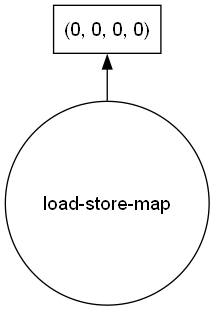

In [ ]:
test.map.images.visualize(filename=None)

In [ ]:
import scipy.ndimage as ndi
import scipy.io as io
from dask_image import ndfilters as dask_ndi
from dask_image import imread as dask_io

In [ ]:
test.map.dtype = np.float32

In [ ]:
test.map.apply_lorentz_correction()
test.map.apply_polarization_correction()
test.map.apply_solidangle_correction()

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

In [ ]:
test.map.apply_defect_mask(min_bounds=(-np.inf, 800), max_bounds=(0, np.inf))
test.plot_image(test.map.defect_mask)

In [ ]:
test.map._dask_2_hdf()

In [ ]:
#test.map.estimate_background(method='bruckner', binning=2, min_prominence=1)
test.map.estimate_background(method='bruckner', binning=2, min_prominence=0.1)

In [ ]:
test.plot_image(test.map.images[0, 0] - test.map.background[0, 0])

In [ ]:
test.map.remove_background()

Removing background...done!


In [ ]:
test.map._dask_2_hdf()

In [ ]:
test.map.apply_defect_mask(min_bounds=(-np.inf, 0), max_bounds=(-0, np.inf))
#test.plot_image(test.map.defect_mask)

In [ ]:
test.map._dask_2_hdf()

In [ ]:
cif_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'''
test.clear_phases()
for filename, phase_name in zip(['AMCSD\\Hematite_0017806.cif',
                                 'AMCSD\\Iron-alpha_0011214.cif',
                                 'AMCSD\\Iron-beta_0011215.cif',
                                 'AMCSD\\Iron-delta_0011216.cif',
                                 'AMCSD\\Iron_0011146.cif',
                                 'AMCSD\\Cementite_0013523.cif',
                                 'AMCSD\\Zincite_0011555.cif'],
                                ['Hematite', 'Iron-ferrite', 'Iron-beta',
                                 'Iron-delta', 'Iron-austenite', 'Cementite',
                                 'Zincite']):
    
    test.load_phase(filename, filedir=cif_dir, phase_name=phase_name)

In [ ]:
test.load_phase('AMCSD\\Zincite_0011555.cif', filedir=cif_dir, phase_name="Zincite")

In [ ]:
cif_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'''
test.clear_phases()
test.load_phase('Barker\\1521772COD.cif', filedir=cif_dir, phase_name="LiNbO3 161")
test.load_phase('Barker\\LiNbO3.cif', filedir=cif_dir, phase_name="LiNbO3 148")
test.load_phase('AMCSD\\Platinum_0011157.cif', filedir=cif_dir, phase_name="Platinum")
test.load_phase('AMCSD\\Calcite_0000984.cif', filedir=cif_dir, phase_name="Calcite")
test.load_phase('AMCSD\\Aluminum_0011136.cif', filedir=cif_dir, phase_name="Aluminum")
test.load_phase('AMCSD\\Zincite_0011555.cif', filedir=cif_dir, phase_name="Zincite")
#test.load_phase('AMCSD\\Gold_0011140.cif', filedir=cif_dir, phase_name="Gold")
#test.load_phase('AMCSD\\Chromium_0011209.cif', filedir=cif_dir, phase_name="Chromium BCC")
#test.load_phase('AMCSD\\Chromium_0011170.cif', filedir=cif_dir, phase_name="Chromium HCP")
#test.load_phase('AMCSD\\Chromium_0011144.cif', filedir=cif_dir, phase_name="Chromium FCC")
test.load_phase('AMCSD\\Stibnite_0008636.cif', filedir=cif_dir, phase_name="Stibnite")
test.load_phase('AMCSD\\Silicon_0011243.cif', filedir=cif_dir, phase_name="silicon")
test.load_phase('AMCSD\\Corundum_0009327.cif', filedir=cif_dir, phase_name="sapphire")

XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element Nb used instead of Nb+5
XU.materials: Warning: element Li used instead of Li+1


In [ ]:
stibnite = test.phases['Stibnite']
linbo3 = test.phases['LiNbO3 161']
silicon = test.phases['silicon']
sapphire = test.phases['sapphire']

In [ ]:
test.ai.dist = 0.390449
test.ai.poni1 = 0.111684
test.ai.poni2 = 0.033238
test.ai.rot1 = -0.90864
test.ai.rot2 = -0.00828204
test.ai.rot3 = 3.14
test._del_arr()

In [ ]:
stibnite.get_hkl_reflections(tth_range=(0, np.max(test.tth_arr)), energy=22000)
linbo3.get_hkl_reflections(tth_range=(0, np.max(test.tth_arr)), energy=22000)

In [ ]:
silicon.get_hkl_reflections(tth_range=(0, 90), energy=8000)

In [ ]:
test.select_phases(remove_less_than=0.1)

In [ ]:
stibnite.lattice.symops[1].t

array([0.5, 0. , 0.5])

In [ ]:
linbo.lattice.symops[12].D


array([[-0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0.5]])

In [ ]:
v = linbo.lattice.symops[12].D @ [0, 1, 0]
v /= np.linalg.norm(v)
v

array([0.70710678, 0.70710678, 0.        ])

In [ ]:
linbo.lattice.symops[12].apply_rotation([2, 0, 0])

array([-2.,  0.,  0.])

In [ ]:
print(linbo.lattice.reflection_conditions())

Reflection conditions:
 general: hkil: -h+k+l=3n, hki0: -h+k=3n, hh(-2h)l: l=3n, h-h0l: h+l=3n, l=2n, 000l: l=6n, h-h00: h=3n
     18b: hkil: -h+k+l=3n, hki0: -h+k=3n, hh(-2h)l: l=3n, h-h0l: h+l=3n, l=2n, 000l: l=6n, h-h00: h=3n 
      6a: hkil: l=2n 



In [ ]:
test.calibrate_images()
test.map.apply_defect_mask(min_bounds=(-5, 0.05), max_bounds=(0, np.inf))
test.map.rescale_images(arr_min=0)
test.map.finalize_image()

Composite of current images is not saved. Creating composite.
Calibrating images...

100%|██████████| 36/36 [00:08<00:00,  4.25it/s]

done!
Writing reciprocal positions...done!
Acquring and writing calibration mask...

done!


In [ ]:
test.map.rescale_images(arr_min=0)
test.map.finalize_images()

In [ ]:
test.plot_interactive_map(img_vmin=0, img_vmax=0.1)

In [ ]:
i = np.random.randint(test.map.map_shape[0])
j = np.random.randint(test.map.map_shape[1])
#i, j = 2, 5
#i, j = 25, 32
#i, j = 12, 3
#i, j = 15, 44

#out = spot_search(test.map.images[i, j], bkg_noise=map_noise, multiplier=3, plotme=True, mask=test.map.mask, expansion=0, sigma=3)
out = spot_search(test.map.images[i, j], multiplier=4, plotme=True,
                  mask=test.map.mask, expansion=10, size=3, threshold_method='minimum')

In [ ]:
#test.map.images = rescale_array(test.map.images, lower=0, upper=100)
test.find_spots(multiplier=4, expansion=10, radius=10, size=3, threshold_method='minimum')

Searching images for spots...


100%|██████████| 19656/19656 [10:48<00:00, 30.29it/s]


Estimating spot characteristics...


100%|██████████| 525974/525974 [1:12:22<00:00, 121.12it/s]


Saving spots to hdf...done!


In [ ]:
test.plot_image(spots=True)

In [ ]:
test.fit_spots(GaussianFunctions, max_dist=0.2, sigma=1)

Scheduling blob segmentation for spot fits...


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:00<00:00, 61.36it/s]


Segmenting blobs for spot fits...


100%|██████████| 36/36 [00:09<00:00,  3.77it/s]


Scheduling spot fits...


100%|██████████| 4011/4011 [00:00<00:00, 41009.86it/s]


Fitting spots in blobs...


100%|██████████| 4011/4011 [03:19<00:00, 20.12it/s]

Successfully fit 5103 / 5129 spots ( 99.5 % ).
Saving spots to hdf...done!


In [ ]:
test.initial_spot_analysis()

Extracting more information from peak parameters...


  0%|          | 0/92970 [00:00<?, ?it/s]

100%|██████████| 92970/92970 [00:45<00:00, 2055.43it/s]

done!
Converting peaks positions to q-space...done!


In [ ]:
test.plot_reconstruction([3, 4], plot_residual=True)

In [ ]:
test.plot_image([3, 4], spots=True)

In [ ]:
test.spots

,map_x,map_y,guess_height,guess_img_x,guess_img_y,guess_tth,guess_chi,guess_cen_tth,guess_cen_chi,guess_fwhm_tth,guess_fwhm_chi,guess_int,guess_integrated,guess_fwhm_a,guess_fwhm_b,guess_rot_fwhm_tth,guess_rot_fwhm_chi,qx,qy,qz
0,0,152,0.236513,274,520,28.845786,172.735301,28.854018,172.759844,0.164422,0.431549,7.311077,7.311077,0.164422,0.431549,0.164422,0.431549,-4.124343,0.523963,-1.069552
1,0,153,0.280468,274,520,28.845786,172.735301,28.856457,172.738581,0.150984,0.428625,7.506928,7.506928,0.150984,0.428625,0.150984,0.428625,-4.124467,0.525534,-1.069729
2,0,154,0.261716,273,520,28.848849,172.665470,28.852487,172.678957,0.150759,0.429776,8.707414,8.707414,0.150759,0.429776,0.150759,0.429776,-4.123399,0.529759,-1.069441
3,0,155,0.291227,273,520,28.848849,172.665470,28.854971,172.661808,0.137648,0.424905,8.875942,8.875942,0.137648,0.424905,0.137648,0.424905,-4.123565,0.531035,-1.069621
4,0,156,0.284986,272,520,28.851948,172.595662,28.855439,172.601351,0.148072,0.433446,8.191417,8.191417,0.148072,0.433446,0.148072,0.433446,-4.123063,0.535394,-1.069655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457899,88,133,0.236878,405,685,23.483205,-177.246203,23.483059,-177.251085,0.132923,0.505489,6.785777,6.785777,0.132923,0.505489,0.132923,0.505489,-3.428994,-0.164641,-0.713524
457900,88,141,0.225328,312,517,28.854640,175.408901,28.853605,175.418362,0.154675,0.427690,6.701927,6.701927,0.154675,0.427690,0.154675,0.427690,-4.144153,0.332094,-1.069522
457901,88,142,0.222816,312,517,28.854640,175.408901,28.854172,175.409041,0.145540,0.436269,6.719757,6.719757,0.145540,0.436269,0.145540,0.436269,-4.144173,0.332774,-1.069563
457902,88,143,0.307005,310,517,28.858049,175.268262,28.852243,175.283614,0.144938,0.426297,6.603902,6.603902,0.144938,0.426297,0.144938,0.426297,-4.143182,0.341824,-1.069423


In [ ]:
plot_map = np.zeros(test.map.map_shape)
plot_map[:] = np.nan

for image_index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(image_index, test.map.map_shape)
    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                          & (test.spots['map_y'] == indices[1])]
    
    if len(pixel_df) < 1:
        plot_map[indices] = 0
    else:
        #plot_map[indices] = np.sum(pixel_df['guess_int'])
        #plot_map[indices] = np.sum(pixel_df['fit_amp'])
        #plot_map[indices] = np.sum(pixel_df['fit_integrated'])
        #plot_map[indices] = np.sum(pixel_df['fit_fwhm_chi'])
        #plot_map[indices] = np.mean(pixel_df['fit_chi0'])
        #plot_map[indices] = len(pixel_df)
        #plot_map[indices] = np.nanmedian(pixel_df['qz'])
        #plot_map[indices] = np.nanmin(pixel_df['fit_r_squared'])
        plot_map[indices] = pixel_df.iloc[np.argmax(pixel_df['guess_int'])]['guess_fwhm_chi']
        #plot_map[indices] = pixel_df.iloc[np.argmax(pixel_df['fit_integrated'])]['fit_chi0']


fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(plot_map)
fig.colorbar(im, ax=ax)
ax.set_title('Spot Value')

plt.show()

100%|██████████| 19656/19656 [00:29<00:00, 664.19it/s]


In [ ]:
test.plot_interactive_map(display_map=plot_map, img_vmin=0, img_vmax=0.1, map_vmin=10, map_vmax=5000)

In [ ]:
out = test.integrate1d_image(test.map.images[21, 172])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.plot(out[0], out[1])
ax.set_xlabel('Scattering Angle, 2θ [°]')
ax.set_ylabel('Intensity [a.u.]')

fig.show()

In [ ]:
out[0][-1] - out[0][0]

26.91036393650046

In [ ]:
test.plot_image([21, 172], spots=True)

In [ ]:
np.arange(12, 22.5, 0.5)

array([12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ])

In [ ]:
energies = np.arange(12, 22.5, 0.5)

q_list = []

for en in energies:
    wavelength = energy_2_wavelength(en)
    q_arr = get_q_vect(test.tth_arr, test.chi_arr, wavelength=wavelength)
    q_list.append(q_arr)

q_list = np.asarray(q_list)

In [ ]:
q_list.shape

(21, 3, 486, 768)

In [ ]:
skip = 500
qx, qy, qz = [], [], []
for i, q in enumerate(q_list):
    if i == 0 or i == len(q_list) - 1:
        qx.extend(q[0].ravel()[::skip])
        qy.extend(q[1].ravel()[::skip])
        qz.extend(q[2].ravel()[::skip])
    qx.extend(q[0, 0][::int(np.sqrt(skip))])
    qy.extend(q[1, 0][::int(np.sqrt(skip))])
    qz.extend(q[2, 0][::int(np.sqrt(skip))])

    qx.extend(q[0, -1][::int(np.sqrt(skip))])
    qy.extend(q[1, -1][::int(np.sqrt(skip))])
    qz.extend(q[2, -1][::int(np.sqrt(skip))])

    qx.extend(q[0, :, 0][::int(np.sqrt(skip))])
    qy.extend(q[1, :, 0][::int(np.sqrt(skip))])
    qz.extend(q[2, :, 0][::int(np.sqrt(skip))])

    qx.extend(q[0, :, -1][::int(np.sqrt(skip))])
    qy.extend(q[1, :, -1][::int(np.sqrt(skip))])
    qz.extend(q[2, :, -1][::int(np.sqrt(skip))])

In [ ]:
from scipy.ndimage import sobel, laplace, prewitt, generic_laplace, correlate1d

In [ ]:
def derivative2(input, axis, output, mode, cval):
    #return correlate1d(input, [1, -2, 1], axis, output, mode, cval, 0)
    return correlate1d(input, [1, 1, -8, 1, 1], axis, output, mode, cval, 0)

In [ ]:
lap_image = generic_laplace(sob_image, derivative2)

In [ ]:
test.plot_image(-lap_image)

In [ ]:
test_image = test.map.images[8, 34].copy()
mask = test.map.spot_masks[8, 34]

In [ ]:
sob_image = test_image.copy()
sob_image = gaussian_filter(sob_image, sigma=1)
#sob_x = sobel(sob_image, axis=1)
#sob_y = sobel(sob_image, axis=0)
sob_x = prewitt(sob_image, axis=1)
sob_y = prewitt(sob_image, axis=0)
sob_mag = np.sqrt(sob_x**2 + sob_y**2)
div = sobel(sob_x, axis=1) + sobel(sob_y, axis=0)
mask = div > 2

In [ ]:
test.plot_image(gaussian_filter(test_image, sigma=0) - gaussian_filter(test_image, sigma=1))

In [ ]:
extent = 10
max_h, max_v = np.unravel_index(np.argmax(-div), div.shape)
h_bounds = (max_v - extent, max_v + extent)
v_bounds = (max_h - extent, max_h + extent)
bound_image = sob_image[v_bounds[0] : v_bounds[1], h_bounds[0] : h_bounds[1]]

In [ ]:
test.plot_image(sob_x)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.imshow(bound_image)

scale = 1

sob_x = sobel(bound_image, axis=1) * scale
sob_y = sobel(bound_image, axis=0) * scale

for index in range(np.prod([*bound_image.shape])):
    indices = np.unravel_index(index, bound_image.shape)

    dx = sob_y[indices]
    dy = sob_x[indices]
    

    #if indices[0] > bound_image.shape[0] // 2 - 1:
    #    dx = -dx
    #if indices[1] > bound_image.shape[1] // 2 - 1:
    #    dy = -dy

    ax.arrow(*indices, dx, dy, width=0.00001, head_width=0.1, fc='r', ec='r')


plt.show()

In [ ]:
def intersect(P0, P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate all line direction vectors 
    n = (P1 - P0) / np.linalg.norm(P1 - P0, axis=1)[:, np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:, :, np.newaxis] * n[:, np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:, :, np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R, q, rcond=None)[0]

    return p

400

In [ ]:
test.plot_image(-div)

In [ ]:
lap_image = laplace(sob_image)

In [ ]:
test.plot_image(laplace(lap_image))

In [ ]:
spots = peak_local_max(-div,
                       min_distance=3,
                       labels=-div > 5,
                       num_peaks_per_label=np.inf)

spots = peak_local_max(-lap_image,
                       min_distance=3,
                       labels=-lap_image > 0.009,
                       num_peaks_per_label=np.inf)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(test_image)
fig.colorbar(im, ax=ax)

ax.scatter(spots[:, 1], spots[:, 0], s=1, c='r')

plt.show()

In [ ]:
true_center = (48, 0)

x = np.linspace(-50, 50, 500)
xx, yy = np.meshgrid(x, x)

z = GaussianFunctions.func_2d([xx, yy], 100, *true_center, 10, 10, 0)
noise = np.random.normal(loc=0, scale=0, size=z.shape)

noisy_z = z + noise

In [ ]:
max_center = xx[np.unravel_index(np.argmax(noisy_z), noisy_z.shape)], yy[np.unravel_index(np.argmax(noisy_z), noisy_z.shape)]
mass_center = arbitrary_center_or_mass(noisy_z, xx, yy)

p0 = [np.max(noisy_z), *mass_center, 1, 1, 0]

popt, _ = curve_fit(GaussianFunctions.func_2d, [xx.ravel(), yy.ravel()], noisy_z.ravel(), p0=p0)
gauss_center = (popt[1], popt[2])

sob_x = sobel(gaussian_filter(noisy_z, sigma=3), axis=1)
sob_y = sobel(gaussian_filter(noisy_z, sigma=3), axis=0)
div = sobel(sob_x, axis=1) + sobel(sob_y, axis=0)
div_mask = -div > 10
sob_center = arbitrary_center_or_mass(-div[div_mask], xx[div_mask], yy[div_mask])


c:\Users\emusterma\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(noisy_z, extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
fig.colorbar(im, ax=ax)

for center in [max_center, mass_center, gauss_center, sob_center, true_center]:
    ax.scatter(*center, s=1, c='r')

plt.show()

In [ ]:
print(max_center)
print(mass_center)
print(gauss_center)
print(sob_center)
print(true_center)

(47.99599198396794, -0.10020040080160442)
(45.825804918734526, 1.743815701176553e-16)
(47.999999999999915, 1.743815701176553e-16)
(47.024604588734526, 7.110471171656023e-16)
(48, 0)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(test_image, vmin=0, vmax=100)
fig.colorbar(im, ax=ax)

ax.scatter(spots[:, 1], spots[:, 0], s=1, c='r')

fig.show()

In [ ]:
mask = test.map.spot_masks[74, 32]

In [ ]:
v = np.array([sob_x.ravel()[mask.ravel()], sob_y.ravel()[mask.ravel()]])
p = np.array([test.tth_arr.ravel()[mask.ravel()], test.chi_arr.ravel()[mask.ravel()]])

In [ ]:
blob_mask = label(mask) == 3
masked_mask = blob_mask[mask]
v3 = v[:, masked_mask]
p3 = p[:, masked_mask]

In [ ]:
from itertools import combinations

p_combo = list(combinations(p3.T, 2))
v_combo = list(combinations(v3.T, 2))

In [ ]:
v3[:, 0]

array([-0.09966363,  0.17441136], dtype=float32)

In [ ]:
list(np.asarray(v_combo[0]).T)

[array([-0.09966363, -0.20555624], dtype=float32),
 array([0.17441136, 0.05606079], dtype=float32)]

In [ ]:
p3[:, 0]

array([ 12.67983769, 161.22048606])

In [ ]:
(p_combo[0][0] - p_combo[0][1])

array([-0.03483012, -0.04833402])

In [ ]:
np.asarray(p_combo[0])

array([[ 12.67983769, 161.22048606],
       [ 12.71466782, 161.26882008]])

In [ ]:
A = []
b = []
for pi, vi in zip(p_combo, v_combo):
    A.extend(list(np.asarray(vi).T))
    b.extend(list(pi[0] - pi[1]))

A = np.asarray(A)
b = np.asarray(b)

In [ ]:
A.shape

(315282, 2)

In [ ]:
b.shape

(315282,)

In [ ]:
out = lstsq(A, b)

In [ ]:
out

(array([-0.03950399,  0.03491266]),
 507805.83675365685,
 2,
 array([667.06970721, 612.53409207]))

In [ ]:
print(v3[:, 0])
print(out[0])

[-0.09966363  0.17441136]
[-0.03950399  0.03491266]


In [ ]:
coords = np.mean(v3.T * out[0] + p3.T, axis=0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(*p3, s=1, c='k')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.scatter(*p3, s=1, c='k')

ax.plot(p3.T, (p3 + (v3 * 0.001)).T)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(*(v3.T * out[0] + p3.T).T, s=1, c='k')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(test_image, vmin=0, vmax=0.1)
fig.colorbar(im, ax=ax)

ax.contour(masked)

plt.show()

In [ ]:
test.plot_image(label(mask))

In [ ]:
print(v[:, 0])
print(v[:, 1])
print(p[:, 0])
print(p[:, 1])

[ 0.11835057 -0.01868693]
[0.23047216 0.03114488]
[ 25.59895322 158.62658482]
[ 25.43680711 158.59622021]


In [ ]:
from scipy.linalg import lstsq

out = lstsq(v, p)

ValueError: Input array a should be 2D

In [ ]:
q = p + v @ out[0]

In [ ]:
q[1]

array([ 317.25316964,  317.19244043,  317.25043743, ..., -331.58475086,
       -331.31714126, -331.34545068])

In [ ]:
test.plot_image(sob_mag)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

ax.scatter(qx, qy, qz, c='b', s=1, alpha=0.1)
#ax.plot(qx, qy, qz, c='k')
#ax.plot_trisurf(qx, qy, qz, alpha=0.5, label='detector')
#ax.voxels(np.asarray([qx, qy, qz]), alpha=0.5)
    
fig.show()

In [ ]:
pixel_df = test.spots[(test.spots['map_x'] == 3)
                        & (test.spots['map_y'] == 3)]

In [ ]:
pixel_df.iloc[0]

map_x               3.000000
map_y               3.000000
guess_height        5.275062
guess_img_x        30.000000
guess_img_y       678.000000
guess_tth          38.512360
guess_chi         -13.624387
guess_cen_tth      38.505309
guess_cen_chi     -13.599907
guess_fwhm_tth      0.426384
guess_fwhm_chi      0.687899
guess_int         101.430588
fit_amp             4.920459
fit_tth0           38.504399
fit_chi0          -13.640256
fit_fwhm_tth        0.126779
fit_fwhm_chi        0.169940
fit_theta           6.327112
fit_offset          0.138128
fit_r_squared       0.859608
fit_integrated      0.120120
fit_fwhm_a          0.144735
fit_fwhm_b          0.154934
qx                 -4.599082
qy                 -1.116056
qz                 -1.652888
Name: 51, dtype: float64

In [ ]:
test.plot_image(spots=True)

In [ ]:
test.plot_reconstruction([26, 21])

In [ ]:
test.plot_q_space(pixel_indices=[26, 21])

In [ ]:
#fig = plt.figure()
new_fig = test.phases['LiNbO3 148'].show_unitcell()
new_fig.axes[-1].set_aspect('equal')
plt.show()

In [ ]:
for ind, hkil in enumerate(hkl_2_hkil(all_hkls)):
    h, k, i, l = hkil
    if h == 1 and k == 1:
        print(ind)

13
20
22
44
46
130
139
276
281
518
520
850
852


In [ ]:
skip = 500

all_hkls, all_qs, all_fs = generate_reciprocal_lattice(test.phases['sapphire'], tth_range=(0, 60))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

plot_qs = euler_rotation(all_qs, -60, 0, 0)

ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs/20)
#ax.scatter(*np.asarray(all_qs).T, c='k', s=all_fs/20)
ax.scatter(0, 0, 0, c='k', s=10)

ax.scatter(*np.asarray(plot_qs)[13], c='r', s=10)

for en in [10.125, 10.2, 14.55, 18.375, 19.225, 20.25, 20.375]:

    q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=energy_2_wavelength(en))

    # Plot sampled Ewald sphere
    q_mask = q[:, test.map.mask]
    ax.plot_trisurf(q_mask[0].ravel()[::skip],
                    q_mask[1].ravel()[::skip],
                    q_mask[2].ravel()[::skip],
                    alpha=0.5, label='detector')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
are_coplanar([[-2, 3, -5], [-2, 3, -2], [-3, 4, -4], [-4, 5, -6]])

True

In [ ]:
q1 = get_q_vect(test.tth_arr, test.chi_arr, wavelength=energy_2_wavelength(10.125))
q2 = get_q_vect(test.tth_arr, test.chi_arr, wavelength=energy_2_wavelength(22))

In [ ]:
q1 = get_q_vect(test.tth_arr, test.chi_arr, wavelength=energy_2_wavelength(10.45))
#plot_qs = euler_rotation(all_qs, -60, 0, 0)
dist = euclidean_distances(plot_qs, q1.reshape(3, -1).T)
dist[dist == 0] = np.nan
indices = np.unravel_index(np.argmin(dist[dist > 0]), dist.shape)
min_dist = dist[indices]
min_hkl = all_hkls[indices[0]]
print(f'Closest reflection is the {min_hkl} at {min_dist:.4f} Å⁻¹ from the detector.')

Closest reflection is the (-2, 3, -5) at 0.3401 Å⁻¹ from the detector.


In [ ]:
max_depth = 0

for q1_i, q2_i in tqdm(zip(q1.reshape(3, -1).T, q2.reshape(3, -1).T)):
    dist = euclidean_distances(q1_i.reshape(-1, 1).T, q2_i.reshape(-1, 1).T)[0, 0]
    max_depth = np.max([dist, max_depth])

373248it [01:14, 5004.75it/s]


In [ ]:
q_range = list(q1.reshape(3, -1).T) + list(q2.reshape(3, -1).T)

In [ ]:
all_hkls, all_qs, all_fs = generate_reciprocal_lattice(test.phases['sapphire'], tth_range=(0, 60))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

plot_qs = euler_rotation(all_qs, -60, 0, 0)
ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs/20)
#ax.scatter(*np.asarray(all_qs).T, c='k', s=all_fs/20)
ax.scatter(0, 0, 0, c='k', s=10)

ax.scatter(*np.asarray(plot_qs)[13], c='r', s=10)

for theta in [0, 5, 5.5, 12.25, 13.625, 14.20, 15.55]:
    theta = np.radians(theta)

    q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=energy_2_wavelength(18))

    Ry = np.array([[np.cos(theta), 0, -np.sin(theta)],
                   [0, 1, 0],
                   [np.sin(theta), 0, np.cos(theta)]])

    # Plot sampled Ewald sphere
    q_mask = q[:, test.map.mask]

    q_mask = (q_mask.T @ Ry).T
    ax.plot_trisurf(q_mask[0].ravel()[::skip],
                    q_mask[1].ravel()[::skip],
                    q_mask[2].ravel()[::skip],
                    alpha=0.5, label='detector')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
are_coplanar([[1, 0, 0], [2, 0, 0], [1, 1, 0]])

True

In [ ]:
pixel_indices = [0, 0]
skip = 500

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

plot_qs = euler_rotation(all_qs, 10, -20, 0)

ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
ax.scatter(0, 0, 0, c='k', s=10)

# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=test.wavelength)

if pixel_indices is not None:
    pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                            & (test.spots['map_y'] == pixel_indices[1])].copy()


if pixel_indices is not None:
    ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Plot sampled Ewald sphere
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')

ax.scatter(qx, qy, qz, c='b', s=1, alpha=0.1)

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
pixel_indices = [0, 0] #[26, 21]
skip = 500

#fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=200, subplot_kw={'projection':'3d'})
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_axes([0, 0, 0.5, 1], projection='3d')
#ax = fig.add_subplot(projection='3d')

plot_qs = euler_rotation(all_qs, 10, -20, 0)
recip_latt = ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
ax.scatter(0, 0, 0, c='k', s=10)

# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=test.wavelength)

if pixel_indices is not None:
    pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                            & (test.spots['map_y'] == pixel_indices[1])].copy()


if pixel_indices is not None:
    ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Plot sampled Ewald sphere
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')

phi1, PHI, phi2 = 10, -20, 0
euler_angles = {'phi1' : phi1,
                'PHI' : PHI,
                'phi2': phi2}
euler_bounds = [[-180, 180], [0, 180], [-180, 180]]
slider_lst = []
update_lst = []

slider_vpos = np.linspace(0.8, 0.1, 3)

for i, key in enumerate(euler_angles.keys()):
    slider_ax = fig.add_axes

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.7, slider_vpos[i], 0.2, 0.03])
    euler_slider = Slider(
        ax=axfreq,
        label=f'{key} [deg]',
        valmin=euler_bounds[i][0],
        valmax=euler_bounds[i][1],
        valinit=euler_angles[key],
    )

    slider_lst.append(euler_slider)

    # The function to be called anytime a slider's value changes
    def update_factory(key):
        def update(val):
            global recip_latt
            euler_angles[key] = val
            plot_qs = euler_rotation(all_qs, *euler_angles.values())
            recip_latt.remove()
            recip_latt = ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
            fig.canvas.draw_idle()
        return update

    update_lst.append(update_factory(key))
    slider_lst[i].on_changed(update_lst[i])

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
test.spots = pd.read_hdf(test.hdf_path, key='xrdmap/reflections/spots')

In [ ]:
dropped_indices = []

for index in test.spots.index:
    spot = test.spots.loc[index]
    if spot['fit_amp'] - spot['fit_offset'] < 0.5:
        dropped_indices.append(index)

In [ ]:
test.spots = test.spots.drop(index = dropped_indices)

In [ ]:
test.plot_image([15, 23], spots=True)

In [ ]:
pixel_indices = 5, 28
pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                        & (test.spots['map_y'] == pixel_indices[1])].copy()

fit_ori, fit_min = iterative_dictionary_indexing(pixel_df, test.phases['Stibnite'], [np.min(test.tth_arr), np.max(test.tth_arr)],
                                                 cut_off=0.05,
                                                 start_angle=20,
                                                 angle_resolution=0.001, 
                                                 euler_bounds=[[0, 180], [0, 90], [0, 180]])

all_hkls, all_qs, all_fs = generate_reciprocal_lattice(test.phases['Stibnite'], tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)))

NameError: name 'test' is not defined

In [ ]:
test.spots.drop(index=311, inplace=True)

In [ ]:
test.plot_image(pixel_indices, spots=True)

In [ ]:
skip = 500

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

plot_qs = euler_rotation(all_qs, *fit_ori[-2])

ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
ax.scatter(0, 0, 0, c='k', s=10)

# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=test.wavelength)

if pixel_indices is not None:
    pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                            & (test.spots['map_y'] == pixel_indices[1])].copy()


if pixel_indices is not None:
    ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Plot sampled Ewald sphere
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
fit_ori

[(40, 160, 280),
 (200, 50.0, 280),
 (200.0, 50.0, 280.0),
 (350.0, 160.0, 237.5),
 (-2.5, 161.25, 243.75),
 (315.625, 51.875, 284.375),
 (315.625, 51.875, 284.375),
 (-5.78125, 160.78125, 241.09375),
 (75.9375, 51.796875, 284.0625),
 (234.6484375, 160.8203125, 241.4453125),
 (234.51171875, 160.80078125, 241.328125),
 (234.521484375, 160.80078125, 241.337890625),
 (-5.4541015625, 160.8056640625, 241.357421875),
 (-5.4541015625, 160.8056640625, 241.357421875),
 (315.95458984375, 51.805419921875, 284.072265625),
 (315.95458984375, 51.805419921875, 284.072265625)]

In [ ]:
spot_qs = pixel_df[['qx', 'qy', 'qz']].values
dist = euclidean_distances(spot_qs, euler_rotation(all_qs, *fit_ori[-12]))

In [ ]:
fit_hkls = []

for spot in range(len(dist)):
    fit_hkls.append(all_hkls[np.argmin(dist[spot])])
fit_hkls = np.asarray(fit_hkls)

In [ ]:
np.unique(fit_hkls, axis=0)

array([[-10,   0,  -4],
       [ -9,  -1,  -3],
       [ -9,   0,  -3],
       [ -9,   1,  -3],
       [ -8,   1,  -2],
       [ -7,  -1,  -2],
       [ -7,   0,  -2],
       [ -7,   1,  -2],
       [ -6,   0,  -1],
       [ -5,   1,  -1],
       [ -4,  -1,  -1],
       [ -4,   1,  -1]])

In [ ]:
are_coplanar(np.unique(fit_hkls, axis=0))

False

In [ ]:
from scipy import linalg

x, res, rnk, s = linalg.lstsq(fit_hkls, spot_qs)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})


ax.quiver([0, 0, 0], [0, 0, 0], [0, 0, 0], *x.T)

plt.show()

In [ ]:
b1, b2, b3 = x
b1_mag = linalg.norm(b1)
b2_mag = linalg.norm(b2)
b3_mag = linalg.norm(b3)
beta1 = np.arccos(np.dot(b3, b2) / (linalg.norm(b3) * linalg.norm(b2)))
beta2 = np.arccos(np.dot(b1, b3) / (linalg.norm(b1) * linalg.norm(b3)))
beta3 = np.arccos(np.dot(b1, b2) / (linalg.norm(b1) * linalg.norm(b2)))

In [ ]:
a1 = (2 * np.pi * np.cross(b2, b3)) / (b1 @ (np.cross(b2, b3)))
a2 = (2 * np.pi * np.cross(b3, b1)) / (b1 @ (np.cross(b2, b3)))
a3 = (2 * np.pi * np.cross(b1, b2)) / (b1 @ (np.cross(b2, b3)))
a1_mag = linalg.norm(a1)
a2_mag = linalg.norm(a2)
a3_mag = linalg.norm(a3)
alpha1 = np.arccos(np.dot(a3, a2) / (linalg.norm(a3) * linalg.norm(a2)))
alpha2 = np.arccos(np.dot(a1, a3) / (linalg.norm(a1) * linalg.norm(a3)))
alpha3 = np.arccos(np.dot(a1, a2) / (linalg.norm(a1) * linalg.norm(a2)))

In [ ]:
print(linalg.norm(a1))
print(linalg.norm(a2))
print(linalg.norm(a3))

11.682404085497277
5.287620223096001
15.36757242451438


In [ ]:
stibnite = test.phases['Stibnite']
I = np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
A_meas = np.asarray([[a1_mag, a2_mag * np.cos(alpha3), a3_mag * np.cos(alpha2)],
                     [0, a2_mag * np.sin(alpha3), -a3_mag * np.sin(alpha2) * np.cos(beta1)],
                     [0, 0, 1 / b3_mag]])
a1_ref = stibnite.a
a2_ref = stibnite.b
a3_ref = stibnite.c
alpha1_ref = stibnite.alpha
alpha2_ref = stibnite.beta
alpha3_ref = stibnite.gamma
beta1_ref = np.arccos(np.dot(stibnite.B[2], stibnite.B[1]) / (linalg.norm(stibnite.B[2]) * linalg.norm(stibnite.B[1])))
b3_ref = linalg.norm(stibnite.B[2])


A_ref = np.asarray([[a1_ref, a2_ref * np.cos(alpha3_ref), a3_ref * np.cos(alpha2_ref)],
                    [0, a2_ref * np.sin(alpha3_ref), -a3_ref * np.sin(alpha2_ref) * np.cos(beta1_ref)],
                    [0, 0, 1 / b3_ref]])

In [ ]:
A_meas

array([[11.0035646 ,  0.0585458 , -0.03931784],
       [ 0.        ,  3.79980785,  0.1230244 ],
       [ 0.        ,  0.        ,  1.79850057]])

In [ ]:
A_ref

array([[11.314     , -1.71925847, -5.033659  ],
       [ 0.        ,  3.4302652 , -0.        ],
       [ 0.        ,  0.        ,  1.78794663]])

In [ ]:
delta = (0) * I
T = (A_meas + delta) @ linalg.inv(A_ref)

In [ ]:
T

array([[0.97256183, 0.50451813, 2.71609158],
       [0.        , 1.10773005, 0.06880765],
       [0.        , 0.        , 1.00590283]])

In [ ]:
(A_meas + delta) - (T @ A_ref)

array([[ 0., -0., -0.],
       [ 0., -0.,  0.],
       [ 0.,  0.,  0.]])

In [ ]:
ep = 0.5 * (T.T + T) - I
w = 0.5 * (T.T - T) - I

In [ ]:
A = np.asarray([a1 / linalg.norm(a1_ref), a2 / linalg.norm(a2_ref), a3 / linalg.norm(a3_ref)])
#A = np.asarray([a1, a2, a3])
p, u = linalg.polar(A, side='left')
print(u - I)
print(p)

[[-0.02746914  0.00756478 -0.00174114]
 [ 0.00756478 -0.00961917  0.00541227]
 [-0.00174114  0.00541227  0.00595246]]
[[-0.00528622  0.66911742  0.74313789]
 [-0.52615367 -0.63382323  0.56694835]
 [ 0.85037308 -0.38800772  0.35540912]]


In [ ]:
A = np.asarray([a1 / linalg.norm(a1_ref), a2 / linalg.norm(a2_ref), a3 / linalg.norm(a3_ref)])
#A = np.asarray([a1, a2, a3])
p, u = linalg.polar(x / 2 / np.pi, side='left')
print(u - 1)
print(p)

[[-0.90911509 -1.00104312 -0.99984067]
 [-1.00104312 -0.73681626 -1.00072048]
 [-0.99984067 -1.00072048 -0.91150995]]
[[-0.00730817  0.66669301  0.7452966 ]
 [-0.52838637 -0.63534477  0.56315617]
 [ 0.84897258 -0.38968893  0.3569147 ]]


In [ ]:
I = np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
euler_rotation(I, *fit_ori[-1])

array([[-0.00647293,  0.66357075,  0.74808553],
       [-0.52116317, -0.64070588,  0.56381284],
       [ 0.85343251, -0.38622511,  0.34997588]])

In [ ]:
spot_qs = pixel_df[['qx', 'qy', 'qz']].values
all_hkls, all_qs, all_fs = generate_reciprocal_lattice(test.phases['Stibnite'], tth_range=(np.min(test.tth_arr), np.max(test.tth_arr)))

dist = euclidean_distances(all_qs)
min_q = np.min(dist[dist > 0])

euler_map = np.empty((*test.map.map_shape, 3))
fit_map = np.empty(test.map.map_shape)

for index in tqdm(range(test.map.num_pixels)):
    indices = np.unravel_index(index, test.map.map_shape)
    phi1, PHI, phi2 = np.nan, np.nan, np.nan

    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                        & (test.spots['map_y'] == indices[1])].copy()
    pixel_df.dropna(inplace=True)

    # Conditional to avoid too few spots for theoretical indexing
    if len(pixel_df) < 3:
        euler_map[indices] = phi1, PHI, phi2
        continue
    
    # Conditional to avoid single spot from one grain
    dist = euclidean_distances(pixel_df[['qx', 'qy', 'qz']].values)
    if np.max(dist) < min_q:
        euler_map[indices] = phi1, PHI, phi2
        continue
    
    fit_ori, fit_min = iterative_dictionary_indexing(pixel_df, test.phases['Stibnite'], [np.min(test.tth_arr), np.max(test.tth_arr)],
                                                 cut_off=0.05,
                                                 start_angle=20,
                                                 angle_resolution=0.01, 
                                                 euler_bounds=[[0, 180], [0, 90], [0, 180]])
    
    euler_map[indices] = fit_ori[-1]
    fit_map[indices] = fit_min[-1]

100%|██████████| 1296/1296 [10:14<00:00,  2.11it/s]


In [ ]:
g = g_func(*euler_map.reshape(test.map.num_pixels, 3).T)

In [ ]:
ipole = [0, 1, 0]

colors, r, theta = [], [], []
for i in range(len(g)):
    
    # Take only part of the orientation matrix
    V = np.dot(g[i], ipole) # order is g, then ipole

    # Determine pixel color according to unit triangle
    R, G, B = 0, 0, 0
    base = 30 / 255 #all pixels are a bit brighter
    R=np.abs(V[2]) + base # referenced to crystallographic axes, but should be able to reference any axis
    G=np.abs(V[0]) + base
    B=np.abs(V[1]) + base

    # Normalize and brighten colors
    max_c = np.max([R,G,B])
    R = R / max_c
    G = G / max_c
    B = B / max_c
    
    # Setting pixel transparency if called
    A=1
    colors.append([R, G, B, A])

colors = np.asarray(colors)
colors = colors.reshape((*test.map.map_shape, 4))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

ax.imshow(colors)
ax.set_title(str(ipole))

plt.show()

In [ ]:
norm_fit_map = fit_map.copy()

for index in range(test.map.num_pixels):
    indices = np.unravel_index(index, test.map.map_shape)
    
    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                        & (test.spots['map_y'] == indices[1])].copy()
    pixel_df.dropna(inplace=True)

    # Conditional to avoid too few spots for theoretical indexing
    if len(pixel_df) < 3:
        euler_map[indices] = phi1, PHI, phi2
        continue
    
    # Conditional to avoid single spot from one grain
    dist = euclidean_distances(pixel_df[['qx', 'qy', 'qz']].values)
    if np.max(dist) < min_q:
        euler_map[indices] = phi1, PHI, phi2
        continue

    norm_fit_map[indices] /= len(pixel_df)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

im = ax.imshow(norm_fit_map)
fig.colorbar(im, ax=ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

trans_colors = colors.copy()
trans_colors[:, :, -1] = -rescale_array(norm_fit_map, lower=-1, upper=0)
mask = trans_colors[:, :, -1] == colors[:, :, -1]
trans_colors[mask, -1] = 0

ax.imshow(trans_colors)
ax.set_title(str(ipole))
ax.set_facecolor('black')

plt.show()

In [ ]:
test.plot_interactive_map(display_map=colors, img_vmin=0, img_vmax=1)

In [ ]:
skip = 500
pixel_indices = [15, 21]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

plot_qs = euler_rotation(all_qs, *euler_map[*pixel_indices])

ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
ax.scatter(0, 0, 0, c='k', s=10)

# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=test.wavelength)

if pixel_indices is not None:
    pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                            & (test.spots['map_y'] == pixel_indices[1])].copy()


if pixel_indices is not None:
    ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Plot sampled Ewald sphere
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
from scipy.spatial.transform import Rotation

In [ ]:
Rotation.from_quat([1, 0, 0, 1]).apply([0, 0, 1])

array([ 0., -1.,  0.])

In [ ]:
pixel_indices = [26, 21]
skip = 500

#fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=200, subplot_kw={'projection':'3d'})
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_axes([0, 0, 0.5, 1], projection='3d')
#ax = fig.add_subplot(projection='3d')

quat = [0, 0, 0, 1]

plot_qs = Rotation.from_quat(quat).apply(all_qs)
recip_latt = ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
ax.scatter(0, 0, 0, c='k', s=10)

# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

q = get_q_vect(test.tth_arr, test.chi_arr, wavelength=test.wavelength)

if pixel_indices is not None:
    pixel_df = test.spots[(test.spots['map_x'] == pixel_indices[0])
                            & (test.spots['map_y'] == pixel_indices[1])].copy()


if pixel_indices is not None:
    ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Plot sampled Ewald sphere
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')


quats = {
    'qx' : quat[0],
    'qy' : quat[1], 
    'qz' : quat[2],
    'qr' : quat[3]
}

quat_bounds = [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]
slider_lst = []
update_lst = []

slider_vpos = np.linspace(0.8, 0.1, len(quats.keys()))

for i, key in enumerate(quats.keys()):
    slider_ax = fig.add_axes

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.7, slider_vpos[i], 0.2, 0.03])
    quat_slider = Slider(
        ax=axfreq,
        label=f'{key} [deg]',
        valmin=quat_bounds[i][0],
        valmax=quat_bounds[i][1],
        valinit=quats[key],
    )

    slider_lst.append(quat_slider)

    # The function to be called anytime a slider's value changes
    def update_factory(key):
        def update(val):
            global recip_latt
            quats[key] = val
            #plot_qs = euler_rotation(all_qs, *euler.values())
            plot_qs = Rotation.from_quat(list(quats.values())).apply(all_qs)
            recip_latt.remove()
            recip_latt = ax.scatter(*np.asarray(plot_qs).T, c='k', s=all_fs / 50, alpha=0.75)
            fig.canvas.draw_idle()
        return update

    update_lst.append(update_factory(key))
    slider_lst[i].on_changed(update_lst[i])

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
list(quats.values())

[0.1130952380952408, 0, 0, 1]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=200, subplot_kw={'projection': '3d'})

num = 10

x = np.linspace(0, 1, num + 1)
y = np.linspace(0, 1, num + 1)
z = np.linspace(0, 1, num + 1)
w = np.linspace(0, 1, num//2 + 1)
xx, yy, zz, ww = np.meshgrid(x, y, z, w)

quats = np.array([xx.ravel(), yy.ravel(), zz.ravel(), ww.ravel()])
#quats /= np.linalg.norm(quats, axis=0)
quats = quats[:, ~(np.sum(np.abs(quats), axis=0) == 0)]
quats = quats[:, ~(np.sum(np.abs(quats), axis=0) == 0)]
#quats = quats[quats != np.array([0, 0, 0, 0])]
plot_qs = Rotation.from_quat(quats.T).apply([0, 0, -1])

ax.scatter(*plot_qs.T, s=5, c='k')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=200, subplot_kw={'projection': '3d'})

step = 15

phi1_list = np.arange(*euler_bounds[0], step)
PHI_list = np.arange(*euler_bounds[1], step)
phi2_list = np.arange(*euler_bounds[2], step)
orientations = list(product(phi1_list, PHI_list, phi2_list))

plot_qs = []
for orientation in orientations: 
    plot_qs.append(euler_rotation([0, 0, 1], *orientation))
plot_qs = np.asarray(plot_qs)

ax.scatter(*plot_qs.T, s=5, c='k')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
new_orientations = []

step = 5
phi1, PHI, phi2 = 0, 0, 0
new_phi1 = [phi1 - step, phi1, phi1 + step]
new_PHI = [PHI - step, PHI, PHI + step]
new_phi2 = [phi2 - step, phi2, phi2 + step]

new_orientations = product(new_phi1, new_PHI, new_phi2)

#for sub_orientation in sub_orientations:
#    if sub_orientation not in new_orientations:
#        new_orientations.append(sub_orientation)
#
#orientations = new_orientations

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=200, subplot_kw={'projection': '3d'})

plot_qs = []
for orientation in orientations: 
    plot_qs.append(euler_rotation([0, 0, 1], *orientation))
plot_qs = np.asarray(plot_qs)

ax.scatter(*plot_qs.T, s=5, c='k')

plot_qs = []
for orientation in new_orientations: 
    plot_qs.append(euler_rotation([0, 0, 1], *orientation))
plot_qs = np.asarray(plot_qs)

ax.scatter(*plot_qs.T, s=5, c='r')

ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

plt.show()

In [ ]:
quats[:, 7315]

array([0., 0., 0., 0.])

In [ ]:
d_2_tth(2.068, wavelength=(energy_2_wavelength(8)))

44.01283779677743

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(test.spots['fit_amp'], test.spots['fit_r_squared'], s=1, c='k', alpha=0.5)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

ax.scatter(test.spots['guess_fwhm_chi'], test.spots['fit_fwhm_chi'], s=1, c='k', alpha=0.5)

plt.show()

In [ ]:
np.max(test.spots['fit_fwhm_tth'])

14.999999999999998

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image

#tth = test.tth
intensity = np.sum(test.map.composite_image, axis=0)
#pixels = np.sum(test.map.calibration_mask, axis=0)

x, bins, _ = ax.hist(test.spots['guess_cen_tth'].values, bins=2000, weights=test.spots['guess_height'].values, label='spot center', density=True)
#ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)

image = test.map.composite_image

#tth = test.tth
#intensity = np.sum(test.map.composite_image, axis=0)
#pixels = np.sum(test.map.calibration_mask, axis=0)

x, bins, _ = ax.hist(test.spots['fit_tth0'].values, bins=2500, label='spot center', density=True)
#ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

x, bins, _ = ax.hist(test.spots['fit_fwhm_tth'].values, bins=500, label='spot center', density=True)
ax.legend()

plt.show()

In [ ]:
test.plot_image(test.ai.position_array()[:, :, 2])

In [ ]:
x_coords, y_coords = np.meshgrid(test.tth, test.chi[::-1])
q = q_vect(x_coords, y_coords, wavelength=test.wavelength)

pixel_df = test.spots[(test.spots['map_x'] == 1)
                        & (test.spots['map_y'] == 0)].copy()

In [ ]:
q = q_vect(test.ai.twoThetaArray(), test.ai.chiArray(), wavelength=test.wavelength, radians=True)

In [ ]:
np.tile(np.array([0, 0, 1]), tth.shape).shape

(486, 2304)

In [ ]:
a = np.array([0, 0, 1])
b = np.full((486, 768, 3), a)

In [ ]:
np.asarray([[0, 0, 1],] * len(test.tth)).T.shape

(3, 1483)

In [ ]:
# Q-space plotting

skip = 500

x_coords, y_coords = np.meshgrid(test.tth, test.chi[::-1])
q = q_vect(x_coords, y_coords, wavelength=test.wavelength)

pixel_df = test.spots[(test.spots['map_x'] == 1)
                        & (test.spots['map_y'] == 0)].copy()


fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

# Plot sampled Ewald sphere
#ax.scatter(q[0].ravel()[::skip], q[1].ravel()[::skip], q[2].ravel()[::skip], s=1, c='k', alpha=0.2)
q_mask = q[:, test.map.mask]
ax.plot_trisurf(q_mask[0].ravel()[::skip],
                q_mask[1].ravel()[::skip],
                q_mask[2].ravel()[::skip],
                alpha=0.5, label='detector')


# Plot full Ewald sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 2 * np.pi / test.wavelength
x =  radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z - radius, alpha=0.2, color='k', label='Ewald sphere')

ax.scatter(*test.spots.loc[0:1000, ['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')
#ax.scatter(*pixel_df[['qx', 'qy', 'qz']].values.T, s=1, c='r', label='spots')

# Sample geometry
ax.quiver([0, 0], [0, 0], [-2 * radius, -radius], [0, 0], [0, 0], [radius, radius], colors='k')
ax.scatter(0, 0, 0, marker='o', s=10, facecolors='none', edgecolors='k', label='transmission')
ax.scatter(0, 0, -radius, marker='h', s=10, c='b', label='sample')

# Detector extent
#corner_indices = np.array([[0, 0], [-1, 0], [0, -1], [-1, -1]]).T
#q_corn = q[:, *corner_indices]
#ax.quiver([0,] * 4,
#          [0,] * 4,
#          [-radius,] * 4,
#          q_corn[0],
#          q_corn[1],
#          q_corn[2] + radius, colors='gray', lw=0.5)


ax.set_xlabel('qx [Å⁻¹]')
ax.set_ylabel('qy [Å⁻¹]')
ax.set_zlabel('qz [Å⁻¹]')
ax.set_aspect('equal')

# Initial view
ax.view_init(elev=-45, azim=90, roll=0)
plt.show()

In [ ]:
tth_arr = test.ai.twoThetaArray()
chi_arr = test.ai.chiArray()

polar_correction = test.ai.polarization(factor=0.9)
solidangle_correction = test.ai.solidAngleArray()
lorentz_correction = 1 / (np.sin(tth_arr / 2) * np.sin(tth_arr))

In [ ]:
tth_num = 1500
chi_num = 1500

blank_image = np.ones(test.map.image_shape)

pyfai_correction = test.integrate_2d(blank_image, tth_num, chi_num, polarization_factor=0.9, correctSolidAngle=True)[0]

corrected_image = blank_image / solidangle_correction / polar_correction

self_correction = test.integrate_2d(corrected_image, tth_num, chi_num, polarization_factor=None, correctSolidAngle=False)[0]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(self_correction)
fig.colorbar(im, ax=ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
residual = pyfai_correction - self_correction
ext = np.max(np.abs(residual))

im = ax.imshow(residual, cmap='bwr', vmin=-ext, vmax=ext)
fig.colorbar(im, ax=ax)

plt.show()

In [ ]:
pyfai_correction - self_correction

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Real-space plotting

skip = 300

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, subplot_kw={'projection':'3d'})

# Plot detector position
xyz = test.ai.position_array()

xyz[:, :, 0] *= -1 # Transform to synchrotron standard. Not sure if correct

x = xyz[:, :, 0].ravel()[::skip]
y = xyz[:, :, 1].ravel()[::skip]
z = xyz[:, :, 2].ravel()[::skip]


ax.plot_trisurf(x, y, z,
                alpha=0.5, label='detector')

# X-ray beam
radius = test.ai.dist
ax.quiver([0], [0], [-radius], [0], [0], [radius], colors='k')
ax.scatter(0, 0, 0, marker='h', s=10, c='b', label='sample')

# Detector
corner_indices = np.array([[0, 0], [-1, 0], [0, -1], [-1, -1]]).T
corn = xyz[*corner_indices].T
ax.quiver([0,] * 4,
          [0,] * 4,
          [0,] * 4,
          corn[0],
          corn[1],
          corn[2], colors='gray', lw=0.5)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_aspect('equal')

# Initial view
ax.view_init(elev=-60, azim=90, roll=0)
plt.show()

In [ ]:
radius

7.6015960742345925

In [ ]:
pixel_df[['qx', 'qy', 'qz']]

,qx,qy,qz
11,-3.236871,-0.327674,-0.731403
10,-2.544562,0.992806,-0.507669
9,-4.712897,-0.427081,-1.652607


In [ ]:
pixel_df.iloc[0][['qx', 'qy', 'qz']].values

array([-3.23687107, -0.32767447, -0.73140263])

In [ ]:
q_diff = pixel_df.iloc[1][['qx', 'qy', 'qz']].values - pixel_df.iloc[2][['qx', 'qy', 'qz']].values
print(q_diff)

[2.16833467 1.41988698 1.14493823]


In [ ]:
q_diff = pixel_df.iloc[0][['qx', 'qy', 'qz']].values - pixel_df.iloc[2][['qx', 'qy', 'qz']].values
print(q_diff)

[1.47602556 0.09940648 0.92120445]


In [ ]:
q_diff[0] / test.phases['LiNbO3 161'].a * 2 * np.pi

1.805080408270403

In [ ]:
hkl_diff = test.phases['LiNbO3 161'].HKL(q_diff)
print(hkl_diff)

[1.00461135 0.0812853  1.97910167]


In [ ]:
hkl_appr = np.round(hkl_diff / np.min(np.abs(hkl_diff))).astype(int)
print(hkl_appr)

[  1 -15  -7]


In [ ]:
test.phases['LiNbO3 161'].lattice.equivalent_hkls(hkl_appr)

{(-15, 14, -7),
 (-14, 15, -7),
 (-1, -14, -7),
 (1, -15, -7),
 (14, 1, -7),
 (15, -1, -7)}

In [ ]:
test.phases['LiNbO3 161'].lattice.equivalent_hkls([1, 0, 4])

{(-1, 1, 4), (0, -1, 4), (1, 0, 4)}

In [ ]:
def vector_angle(V1, V2, radians=False):

    unit_V1 = V1 / np.linalg.norm(V1)
    unit_V2 = V2 / np.linalg.norm(V2)

    theta = np.arccos(np.dot(unit_V1, unit_V2))

    return np.degrees(theta)

In [ ]:
vector_angle(pixel_df.iloc[0][['qx', 'qy', 'qz']].values, pixel_df.iloc[2][['qx', 'qy', 'qz']].values)

6.605844468976728

In [ ]:
np.linalg.norm(test.phases['LiNbO3 161'].Q([0, 1, 0]))

1.4121214249166707

In [ ]:
q1 = q_vect(90, 0, wavelength=2 * np.pi).T[0]
q2 = q_vect(90, 90, wavelength=2 * np.pi).T[0]

In [ ]:
np.round(vector_angle(q1, q2) * 2 , 3)

120.0

In [ ]:
pixel_df.iloc[0][['qx', 'qy', 'qz']].values

array([-3.23687107, -0.32767447, -0.73140263])

In [ ]:
pixel_df.iloc[2][['qx', 'qy', 'qz']].values

array([-4.71289663, -0.42708095, -1.65260708])

In [ ]:
test.map.plot_image(test.map.images[1, 0])

In [ ]:
pixel_df[['fit_x0']]

,fit_x0
11,25.340128
10,21.058268
9,38.500994


In [ ]:
test.phases['LiNbO3 161'].reflections['q']

array([1.69136665, 2.33679777, 2.44586605, 2.79279574, 2.81641399,
       2.97371517, 3.3827333 , 3.71240741, 3.76500558, 3.85035617,
       3.982491  , 4.1743437 , 4.23636427, 4.40171243, 4.67359554,
       4.85093845, 4.8641487 , 4.89173211, 4.95730549, 5.07409995,
       5.08713771, 5.11270853, 5.17588294, 5.27491764, 5.42122374,
       5.44446539])

In [ ]:
test.phases['LiNbO3 161'].reflections['hkl']

array([[ 0,  1,  2],
       [ 1,  0,  4],
       [ 1,  1,  0],
       [ 0,  0,  6],
       [ 1,  1,  3],
       [ 2,  0,  2],
       [ 0,  2,  4],
       [ 1,  1,  6],
       [ 2,  1,  1],
       [ 1,  2,  2],
       [ 0,  1,  8],
       [ 2,  1,  4],
       [ 0,  3,  0],
       [ 1,  2,  5],
       [ 2,  0,  8],
       [ 1,  1,  9],
       [ 1,  0, 10],
       [ 2,  2,  0],
       [ 2,  1,  7],
       [ 0,  3,  6],
       [ 2,  2,  3],
       [ 1,  3,  1],
       [ 3,  1,  2],
       [ 1,  2,  8],
       [ 1,  3,  4],
       [ 0,  2, 10]])

In [ ]:
test.phases['LiNbO3 161'].get_hkl_reflections(tth_range=(0, np.max(test.tth)), energy=test.energy*1e3)

TypeError: '>' not supported between instances of 'list' and 'int'

In [ ]:
test.phases['LiNbO3 161'].reflections['hkl'][19]

array([0, 3, 6])

In [ ]:
pixel_df.iloc[0, columns==['qx', 'qy', 'qz']]

NameError: name 'columns' is not defined

In [ ]:
test.phases['LiNbO3 161'].lattice.equivalent_hkls([0, 3, 6])

{(-3, 0, 6), (0, 3, 6), (3, -3, 6)}

In [ ]:
import xrayutilities as xu

data = xu.simpack.PowderDiffraction(test.phases['LiNbO3 161'], en=test.energy*1e3, tt_cutoff=45)

In [ ]:
linbo.lattice.get_allowed_hkl(qmax=2)

{(-1, 0, 2), (-1, 1, -2), (0, -1, -2), (0, 1, 2), (1, -1, 2), (1, 0, -2)}

In [ ]:
all_refl = linbo.lattice.get_allowed_hkl(qmax=tth_2_q(np.max(test.tth), wavelength=energy_2_wavelength(test.energy)))

In [ ]:
q_list = np.linalg.norm(linbo.Q(*refl_list), axis=1)
#q_list.sort()

In [ ]:
all_refl = linbo.lattice.get_allowed_hkl(qmax=tth_2_q(np.max(test.tth), wavelength=energy_2_wavelength(test.energy)))
all_q = np.linalg.norm(linbo.Q(*all_refl), axis=1)
all_q = np.round(all_q, 10) # Clean up some errors
sort_refl = [x for _, x in sorted(zip(all_q, all_refl))]
all_q.sort()
F_hkl = np.abs(linbo.StructureFactor(sort_refl))
F_hkl = rescale_array(F_hkl, lower=0, upper=100)

In [ ]:
ignore_less = 1
wavelength = energy_2_wavelength(test.energy)

all_refl = linbo.lattice.get_allowed_hkl(qmax=tth_2_q(np.max(test.tth), wavelength=wavelength))
all_q = np.linalg.norm(linbo.Q(*all_refl), axis=1)
all_q = np.round(all_q, 10) # Clean up some errors
sort_refl = [x for _, x in sorted(zip(all_q, all_refl))]
all_q.sort()
F_hkl = np.abs(linbo.StructureFactor(sort_refl))
F_hkl = rescale_array(F_hkl, lower=0, upper=100)

hkl_list = []
q_list = []
int_list = []
tth_list = []
d_list = []

for index, norm_int in enumerate(F_hkl):
    if all_q[index] not in q_list:
        hkl_list.append(sort_refl[index]) # Only takes first hkl value
        q_list.append(all_q[index])
        int_list.append(norm_int)
        tth_list.append(q_2_tth(all_q[index], wavelength=wavelength))
        d_list.append(convert_qd(all_q[index]))
    else:
        int_list[-1] += norm_int # Handles multiplicity
        if np.sum(sort_refl[index]) > np.sum(hkl_list[-1]):
            hkl_list[-1] = sort_refl[index] # bias towards positive hkl values

data = {
    'hkl' : np.array(hkl_list)[int_list > ignore_less],
    'q' : np.array(q_list)[int_list > ignore_less],
    'int' : np.array(int_list)[int_list > ignore_less],
    'tth' : np.array(tth_list)[int_list > ignore_less],
    'd' : np.array(d_list)[int_list > ignore_less]
    }

In [ ]:
cif_dir = '''C:\\Users\\emusterma\\OneDrive - Brookhaven National Laboratory\\Documents\\Postdoc\\Literature\\CIF\\'''

test.load_phase('Barker\\1521772COD.cif', filedir=cif_dir, phase_name="LiNbO3 161")
test.load_phase('Barker\\1521772COD.cif', filedir=cif_dir, phase_name="LiNbO3 new")

test.phases['LiNbO3 new'].reflections = data

XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element Nb used instead of Nb+5
XU.materials: Warning: element Li used instead of Li+1
Did not add LiNbO3 161 since it is already in possible phases.
XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element Nb used instead of Nb+5
XU.materials: Warning: element Li used instead of Li+1


In [ ]:
test.select_phases()

In [ ]:
pixel_df.dropna(axis=0, inplace=True)
pixel_df.sort_values(by=['fit_integrated'], inplace=True)

In [ ]:
q_arr = pixel_df[['qx', 'qy', 'qz']].values

In [ ]:
dist = euclidean_distances(q_arr)

In [ ]:
dist

array([[0.        , 1.50765296, 1.74274231],
       [1.50765296, 0.        , 2.8334851 ],
       [1.74274231, 2.8334851 , 0.        ]])

In [ ]:
def plot_image(xrdmap, image=None, indices=None, title=None,
               mask=None, spots=False, contours=False,
               aspect='auto', vmin=None, 
               return_plot=False,
               **kwargs):
    
    # Check image type
    if image is not None:
        image = np.asarray(image)
        if len(image.shape) == 1 and len(image) == 2:
            indices = tuple(iter(image))
            image = xrdmap.map.images[indices]
        elif len(image.shape) == 2:
            if indices is not None:
                indices = tuple(indices)
        else:
            raise ValueError(f"Incorrect image shape of {image.shape}. Should be two-dimensional.")
    else:
        if indices is not None:
            indices = tuple(indices)
            image = xrdmap.map.images[indices]
        else:
            i = np.random.randint(xrdmap.map.map_shape[0])
            j = np.random.randint(xrdmap.map.map_shape[1])
            indices = (i, j)
            image = xrdmap.map.images[indices]

    # Check for mask
    if mask is not None:
        if mask is True:
            image = image * xrdmap.map.mask
        elif np.asarray(mask).shape == image.shape:
            image = image * mask
        else:
            raise RuntimeError("Error handling mask input.")
        
    # Plot image
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
    # Allow some flexibility for kwarg inputs
    plot_kwargs = {'c' : 'r',
                   'lw' : 0.5,
                   's' : 1}
    for key in plot_kwargs.keys():
        if key in kwargs.keys():
            plot_kwargs[key] = kwargs[key]

    if hasattr(xrdmap.map, 'extent'):
        if vmin == None:
            vmin = 0
        im = ax.imshow(image, extent=xrdmap.extent, vmin=vmin, aspect=aspect, **kwargs)
        ax.set_xlabel('Scattering Angle, 2θ [°]') # Assumes degrees. Need to change...
        ax.set_ylabel('Azimuthal Angle, χ [°]')
    else:
        im = ax.imshow(image, aspect=aspect, **kwargs)
        ax.set_xlabel('X index')
        ax.set_ylabel('Y index')
    fig.colorbar(im, ax=ax) 

    if title is not None:
        ax.set_title(title)
    elif indices is not None:
        ax.set_title(f'Row = {indices[0]}, Col = {indices[1]}')
    elif xrdmap.map.title is not None:
        ax.set_title(xrdmap.map.title)
    else:
        ax.set_title('Input Image')

    if indices is not None:
        # Set some default values

        
        # Plot spots
        if spots and hasattr(xrdmap, 'spots'):
            pixel_df = test.spots[(test.spots['map_x'] == indices[0]) & (test.spots['map_y'] == indices[1])].copy()
            if any([x[:3] == 'fit' for x in pixel_df.keys()]):
                pixel_df.dropna(axis=0, inplace=True)
                spots = pixel_df[['fit_y0', 'fit_x0']].values
            else:
                spots = pixel_df[['guess_ceny', 'guess_cenx']].values
            ax.scatter(spots[:, 1], spots[:, 0], s=plot_kwargs['s'], c=plot_kwargs['c'])
        
        elif spots and not hasattr(xrdmap, 'spots'):
            print('Warning: Plotting spots requested, but xrdmap does not have any spots!')

        # Plot contours
        if contours and hasattr(xrdmap.map, 'spot_masks'):
            blob_img = label(xrdmap.map.spot_masks[indices])
            blob_contours = find_blob_contours(blob_img)
            for i in range(len(blob_contours)):
                blob_contours[i] = estimate_reciprocal_coords(blob_contours[i], image.shape, tth=xrdmap.tth, chi=xrdmap.chi)
            for contour in blob_contours:
                ax.plot(*contour, c=plot_kwargs['c'], lw=plot_kwargs['lw'])
            
        elif contours and not hasattr(xrdmap, 'spot_masks'):
            print('Warning: Plotting spots requested, but xrdmap does not have any spots!')
    
    elif spots or contours:
        print('Warning: Cannot request spots or contours without providing map indices!')

    if return_plot:
        return fig, ax
    
    plt.show()

In [ ]:
plot_image(test, test.map.mask)

In [ ]:
indices = pixel_df.index

In [ ]:
pixel_df.loc[indices[-1], ['guess_height', 'guess_cenx']].values

array([ 0.17024574, 12.70959352])

In [ ]:
def reconstruct_image(xrdmap, indices=None, plot_residual=False, **kwargs):
    if not hasattr(xrdmap, 'spots'):
        raise RuntimeError('xrdmap does not have any spots!')

    if indices is None:
        i = np.random.randint(xrdmap.map.map_shape[0])
        j = np.random.randint(xrdmap.map.map_shape[1])
        indices = (i, j)
    else:
        indices = tuple(indices)
    
    if hasattr(xrdmap, 'spot_model'):
        spot_model = xrdmap.spot_model
    spot_model = GaussianFunctions
    
    pixel_df = test.spots[(test.spots['map_x'] == indices[0]) & (test.spots['map_y'] == indices[1])].copy()
    x_coords, y_coords = np.meshgrid(xrdmap.tth, xrdmap.chi[::-1])

    if any([x[:3] == 'fit' for x in pixel_df.keys()]):
        prefix = 'fit'
        pixel_df.dropna(axis=0, inplace=True)
        param_labels = [x for x in test.spots.loc[0].keys() if x[:3] == 'fit'][:6]
    else:
        prefix = 'guess'
        param_labels = ['height', 'cenx', 'ceny', 'stdx', 'stdy']
        param_labels = [f'guess_{param_label}' for param_label in param_labels]
        spot_model = GaussianFunctions

    fit_args = []
    for index in pixel_df.index:
        fit_args.extend(pixel_df.loc[index, param_labels].values)
        if prefix == 'guess':
            fit_args.append(0) # Filling in theta value

    if len(fit_args) > 0:
        #return fit_args
        recon_image = spot_model.multi_2d([x_coords.ravel(), y_coords.ravel()], 0, *fit_args)
        recon_image = recon_image.reshape(xrdmap.map.calibrated_shape)
    else:
        recon_image = np.zeros(xrdmap.map.calibrated_shape)

    if not plot_residual:
        fig, ax = plot_image(xrdmap, recon_image,
                             return_plot=True, indices=indices,
                             **kwargs)
        plt.show()
    else:
        image = xrdmap.map.images[indices]
        residual = recon_image - image
        ext = np.max(np.abs(residual[xrdmap.map.mask]))
        fig, ax = plot_image(xrdmap, residual,
                             title=f'Residual of ({indices[0]}, {indices[1]})',
                             return_plot=True, indices=indices,
                             vmin=-ext, vmax=ext, cmap='bwr', # c='k',
                             **kwargs)
        plt.show()

In [ ]:
reconstruct_image(test, [1, 1], plot_residual=True, spots=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

nan_mask = ~np.isnan(test.spots['fit_integrated'].values)

ax.scatter(test.spots['guess_stdy'].values[nan_mask], test.spots['fit_sigma_y'].values[nan_mask], alpha=0.5, s=1, c='k')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

nan_mask = ~np.isnan(test.spots['fit_integrated'].values)

ax.scatter(np.array(range(len(test.spots)))[nan_mask], test.spots['guess_height'].values[nan_mask], alpha=0.5, s=1, c='k')

plt.show()

In [ ]:
def iter_rescale_array(arr, lower=0, upper=1, arr_min=None, arr_max=None):
    # Works for arrays of any size including images!
    if arr_min is None:
        arr_min = np.min(arr)
    if arr_max is None:
        arr_max = np.max(arr)
    ext = upper - lower

    @dask.delayed
    def delayed_rescale_array(arr, lower, ext, arr_min, arr_max, indices):
        arr[indices] = lower + ext * ((arr[indices] - arr_min) / (arr_max - arr_min))
        return arr[indices]

    delayed_list = []
    for index in tqdm(range(np.multiply(*arr.shape[:2])), desc='Scheduling...'):
        indices = np.unravel_index(index, arr.shape[:2])

        delayed_list.append(delayed_rescale_array(arr[indices], lower, ext, arr_min, arr_max, indices))

    #return delayed_list
    with TqdmCallback(desc='Computing...', tqdm_class=tqdm):
        dask.compute(*delayed_list)

In [ ]:
test.map.plot_image()

In [ ]:
#nan_med = test.map.med_image
nan_med = median_image
nan_med[~test.map.calibration_mask] = np.nan
ball_bkg = rolling_ball(gaussian_filter(nan_med, sigma=2), radius=50)
ball_bkg[~test.map.calibration_mask] = 0
test.map.remove_background(background=ball_bkg * test.map.calibration_mask)
test.map.images = rescale_array(test.map.images, lower=0, upper=100)

In [ ]:
test.map.update_map_title()
test.map.save_images(units=test.map.calib_unit, labels=['x_ind', 'y_ind', 'chi_ind', 'tth_ind'])

In [ ]:
map_noise = estimate_map_noise(test.map)

In [ ]:
i = np.random.randint(test.map.map_shape[0])
j = np.random.randint(test.map.map_shape[1])

out = spot_search(test.map.images[i, j], bkg_noise=map_noise, multiplier=3, plotme=True)

In [ ]:
test.map.plot_image(out[1] * out[2])

In [ ]:
test.find_spots(multiplier=3)

Characterizing spots...: 100%|██████████| 22193/22193 [09:00<00:00, 41.08it/s]


In [ ]:
test.fit_spots(GaussianFunctions, max_dist=0.75)

Fitting spots in blobs...: 100%|██████████| 19175/19175 [10:19<00:00, 30.95it/s]


Successfully fit 16396 / 22193 spots ( 73.9 % ).


In [ ]:
plot_map = np.zeros(test.map.map_shape)
plot_map[:] = np.nan

for image_index in range(test.map.num_pixels):
    indices = np.unravel_index(image_index, test.map.map_shape)
    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                          & (test.spots['map_y'] == indices[1])]
    
    if len(pixel_df) < 1:
        plot_map[indices] = 0
    else:
        plot_map[indices] = np.sum(pixel_df['guess_int'])
        #plot_map[indices] = np.sum(pixel_df['fit_amp'])
        #plot_map[indices] = np.mean(pixel_df['fit_x0'])
        #plot_map[indices] = len(pixel_df)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(plot_map)
fig.colorbar(im, ax=ax)
ax.set_title('Spot Value')

plt.show()

In [ ]:
test.map.plot_image()

In [ ]:
[test.phases[phase].get_hkl_reflections(tth_range=(np.min(test.tth), np.max(test.tth))) for phase in test.phases];

pot_tth = np.concatenate([test.phases[key].reflections['tth'] for key in test.phases])
pot_hkl = np.concatenate([test.phases[key].reflections['hkl'] for key in test.phases])
pot_phase = np.concatenate([[key,] * len(test.phases[key].reflections['tth']) for key in test.phases])

search_distance = 0.5 # in degrees
this_phase = 'Iron-ferrite'

plot_map = np.zeros(test.map.map_shape)
plot_map[:] = 0

for image_index in range(test.map.num_pixels):
    indices = np.unravel_index(image_index, test.map.map_shape)
    pixel_df = test.spots[(test.spots['map_x'] == indices[0])
                          & (test.spots['map_y'] == indices[1])]
    
    if len(pixel_df) < 1:
        plot_map[indices] = 0
    else:
        for spot_index in range(len(pixel_df)):
            min_arr = np.abs(pot_tth - pixel_df.iloc[spot_index]['guess_cenx'])
            #min_arr = np.array([np.abs(x - pot_tth) for x in pixel_df.loc[spot_index, 'fit_x0']])
            min_arr[min_arr > search_distance] = np.nan
            if np.all(np.isnan(min_arr)):
                continue
            #min_index = [np.nanargmin(x) if np.any(~np.isnan(x)) else None for x in min_arr]
            min_index = np.nanargmin(min_arr)

            if pot_phase[min_index] == this_phase:
                plot_map[indices] += pixel_df.iloc[spot_index]['guess_int']

        #plot_map[indices] = np.sum(pixel_df['guess_int'])
        #plot_map[indices] = np.sum(pixel_df['fit_amp'])
        #plot_map[indices] = np.mean(pixel_df['fit_x0'])
        #plot_map[indices] = len(pixel_df)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(plot_map)
fig.colorbar(im, ax=ax)
ax.set_title(this_phase)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image

tth = test.tth
intensity = np.sum(test.map.composite_image, axis=0)
pixels = np.sum(test.map.calibration_mask, axis=0)

x, bins, _ = ax.hist(test.spots['guess_cenx'].values, bins=2000, weights=test.spots['guess_height'].values, label='spot center', density=True)
ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image

tth = test.tth
intensity = np.sum(test.map.composite_image, axis=0)
pixels = np.sum(test.map.calibration_mask, axis=0)

x, bins, _ = ax.hist(test.spots['fit_x0'].values, bins=2500, label='spot center', density=True)
ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image

tth = test.tth
x, bins, _ = ax.hist(test.spots['fit_x0'].values, bins=2000, label='fit', range=test.extent[:2], alpha=0.5)
x, bins, _ = ax.hist(test.spots['guess_cenx'].values, bins=2000, label='integrated', range=test.extent[:2], alpha=0.5)

#ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image
bins = 2500

guess_val = test.spots['guess_cenx'].values
fit_val = test.spots['fit_x0'].values

tth = test.tth
ext = [np.nanmin([guess_val, fit_val]),
       np.nanmax([guess_val, fit_val])]
x, bins, _ = ax.hist(fit_val, bins=bins, label='fit', alpha=0.5, range=ext)
x, bins, _ = ax.hist(guess_val, bins=bins, label='integrated', alpha=0.5, range=ext)

#ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
thickness = 0.6
corrected_tth = test.tth + (thickness * np.sin(np.radians(test.tth)))
rad = np.radians(corrected_tth / 2)
intensity = np.sum(test.map.composite_image * (np.sin(rad) * np.sin(2 * rad)), axis=0)
intensity = np.sum(test.map.composite_image, axis=0)
pixels = np.sum((test.map.composite_image != 0), axis=0)
phase_vals = phase_selector(intensity / pixels, list(test.phases.values()), corrected_tth)
test.map.images = rescale_array(test.map.images, lower=0, upper=100) # Remove negative values. They break spot stats

In [ ]:
bkg_noise = estimate_map_noise(test)

In [ ]:
i = np.random.randint(test.map.map_shape[0])
j = np.random.randint(test.map.map_shape[1])

out = spot_search(test.map.images[i, j], bkg_noise, multiplier=10, sigma=3, plotme=True)

In [ ]:
test.map.plot_image(test.map.images[i, j] * out[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

bins = 1000
key = 'guess_stdy'
#ax.hist(stat_dict[key], bins=bins, density=True)
ax.hist(stat_dict[key], bins=bins, weights=stat_dict['guess_int'], density=True)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

image = test.map.composite_image

tth = test.tth
intensity = np.sum(test.map.composite_image, axis=0)
pixels = np.sum(test.map.calibration_mask, axis=0)

x, bins, _ = ax.hist(stat_dict['guess_cenx'], bins=2000, weights=stat_dict['guess_height'], label='spot center', density=True)
ax.plot(tth, rescale_array(intensity / pixels, lower=np.min(x), upper=np.max(x)), label='integrated intensity')
ax.legend()

plt.show()

In [ ]:
stat_df = pd.DataFrame.from_dict(stat_dict)

In [ ]:
plot_map = np.zeros(test.map.map_shape)

for pixel_index in range(test.map.num_pixels):
    indices = np.unravel_index(pixel_index, test.map.map_shape)
    pixel_df = stat_df.loc[(stat_df['map_x'] == indices[0]) & (stat_df['map_y'] == indices[1])]

    val = np.mean(pixel_df['guess_int'])

    plot_map[indices] = val

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(np.array(plot_map).reshape(test.map.images.shape[:2]))
fig.colorbar(im, ax=ax)
ax.set_title('Total Reflection Intensity')

plt.show()

In [ ]:
[test.phases[phase].get_hkl_reflections() for phase in test.phases];

In [ ]:
new_out = [np.asarray(x) for x in stat_list]

pot_tth = np.concatenate([test.phases[key].reflections['tth'] for key in test.phases])
pot_hkl = np.concatenate([test.phases[key].reflections['hkl'] for key in test.phases])
pot_phase = np.concatenate([[key,] * len(test.phases[key].reflections['tth']) for key in test.phases])

plot_value = []
search_distance = 0.5 # in degrees
phase = 'Iron-austenite'

for spots in new_out:
    if len(spots.shape) > 1:
        #val = np.sum(spots[:, 5])
        min_arr = np.array([np.abs(x - pot_tth) for x in spots[:, 5]])
        min_arr[min_arr > search_distance] = np.nan
        min_index = [np.nanargmin(x) if np.any(~np.isnan(x)) else None for x in min_arr]
        
        val = 0
        for spot_idx, index in enumerate(min_index):
            if index is None:
                continue
            else:
                #raise Exception
                if pot_phase[index] == phase:
                    val += spots[spot_idx, -1]
        
    else:
        val = 0
    
    plot_value.append(val)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

im = ax.imshow(np.array(plot_value).reshape(test.map.images.shape[:2]))
fig.colorbar(im, ax=ax)
ax.set_title(f'{phase} Total Intensity')

plt.show()

In [ ]:
selected_images = np.median(np.copy(test.map.images[::5, ::5]), axis=(0, 1)) # Randomize for less that certain number of images...
bkg_noise = np.std(selected_images[selected_images != 0])

i = np.random.randint(test.map.images.shape[0])
j = np.random.randint(test.map.images.shape[1])
#i, j = 0, 1
image = test.map.images[i, j]

spot_dict = find_spots(image, bkg_noise,
                               multiplier=10, sigma=3,
                               tth=test.tth, chi=test.chi, plotme=True)
print(len(spot_dict['guess_height']))

In [ ]:
def dask_find_spots(pixel):
    spot_dict, mask = find_spots(pixel, bkg_noise,
                               multiplier=10, sigma=3,
                               tth=test.tth, chi=test.chi)
    return spot_dict, mask

iterable = test.map.images.reshape(test.map.num_pixels, len(test.chi), len(test.tth))
spot_dict_lst = parallel_loop(dask_find_spots, iterable)

In [ ]:
iterable = test.map.images.reshape(test.map.num_pixels, len(test.chi), len(test.tth))

spot_dict_lst = []
mask_lst = []
for pixel in iterable:
    spot_dict, mask = find_spots(pixel, bkg_noise,
                               multiplier=10, sigma=3,
                               tth=test.tth, chi=test.chi)
    spot_dict_lst.append(spot_dict)
    mask_lst.append(mask)

In [ ]:
elements_folder = f'output_tiff_scan2D_{scanid}_xs_sum8ch\\'

element_maps = {}
for element in os.listdir(f'{filedir}{elements_folder}'):
    el_im = io.imread(f'{filedir}{elements_folder}{element}')
    element_maps[str(element[:-5])] = el_im

In [ ]:
key = 'detsum_Fe_K'
#interactive_dynamic_2d_plot(proc_map, range(121), range(121), img_vmin=10, img_vmax=100, display_map=element_maps['detsum_Pt_L'], map_vmin=1e4, map_vmax=1.1e4)
interactive_dynamic_2d_plot(test.map.images, range(test.map.images.shape[0]), range(test.map.images.shape[1]), display_map=element_maps[key], display_title=key)